In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

from scipy.interpolate import griddata

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
!pip install watermark --quiet
%load_ext watermark
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


#### Simulation of field trip

```kdeplot``` is equivalent to R ```dens()```

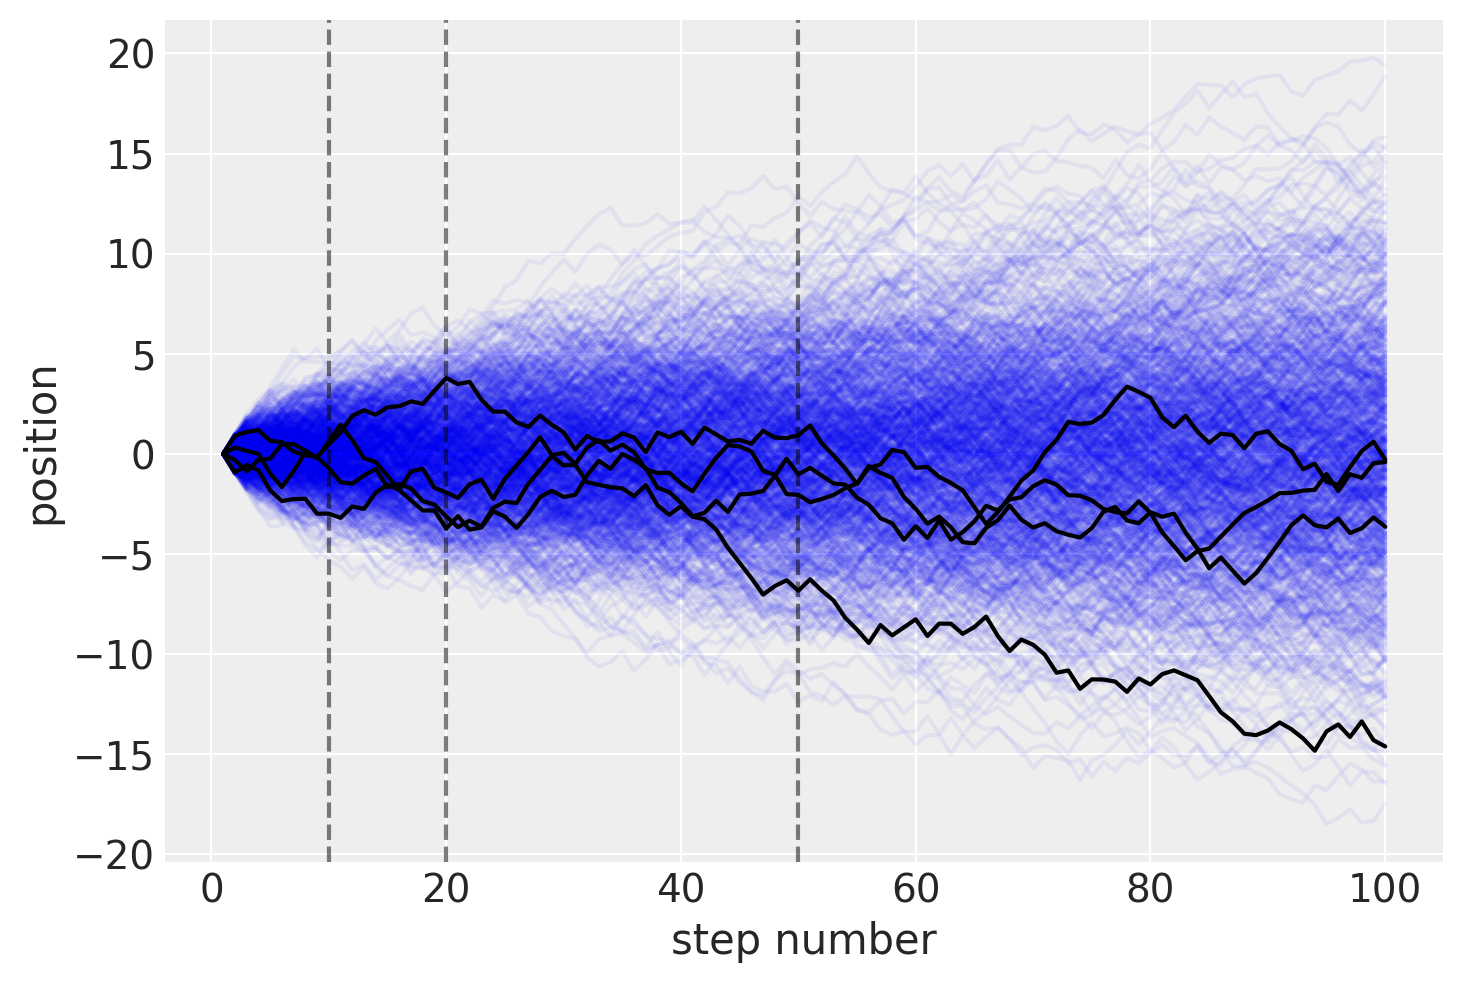

In [3]:
np.random.seed(1234)
steps = 100
repetitions = 1000
x = np.zeros([steps, repetitions])
for i in range(x.shape[1]):
    x[1:, i] = np.cumsum(np.random.uniform(-1, 1, steps - 1))

plt.plot(range(1, steps+1), x[:, :], c="b", alpha=0.05)
plt.plot(range(1, steps+1), x[:,np.random.randint(1,repetitions, 4)], c="k")
plt.axvline(steps/10, linestyle="--", c="k", alpha=0.5)
plt.axvline(steps/5, linestyle="--", c="k", alpha=0.5)
plt.axvline(steps/2, linestyle="--", c="k", alpha=0.5)
plt.xlabel("step number")
plt.ylabel("position")
plt.show()

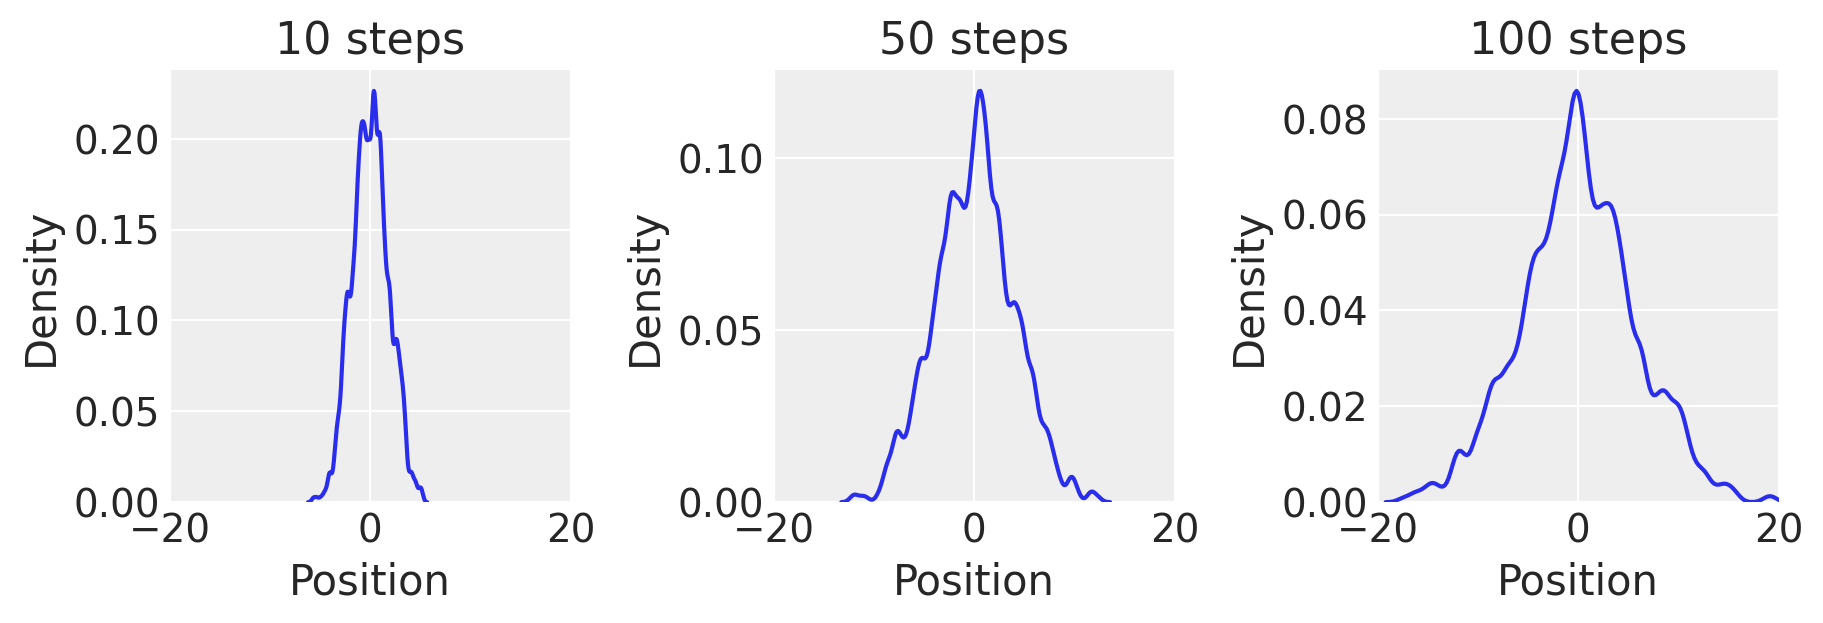

In [4]:
#fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True)
# sns.distplot(x[1:4, :], kde_kws={"bw": 0.01}, ax=ax[0], hist=False)
# sns.distplot(x[1:8, :], kde_kws={"bw": 0.01}, ax=ax[1], hist=False)
# sns.distplot(x[1:, :], kde_kws={"bw": 0.01}, ax=ax[2], hist=False)

fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True)
sns.kdeplot(x[10,:],ax = ax[0], bw_method = 0.1)
sns.kdeplot(x[50,:],ax = ax[1], bw_method = 0.1)
sns.kdeplot(x[steps-1,:],ax = ax[2], bw_method = 0.1)

ax[0].set_title("10 steps")
ax[1].set_title("50 steps")
ax[2].set_title("100 steps")

for i in range(3):
    ax[i].set_ylabel("Density")
    ax[i].set_xlabel("Position")
    ax[i].set_xlim(-20, 20)
    #ax[i].set_xticks([-6, -3, 0, 3, 6])

#### Code 4.1

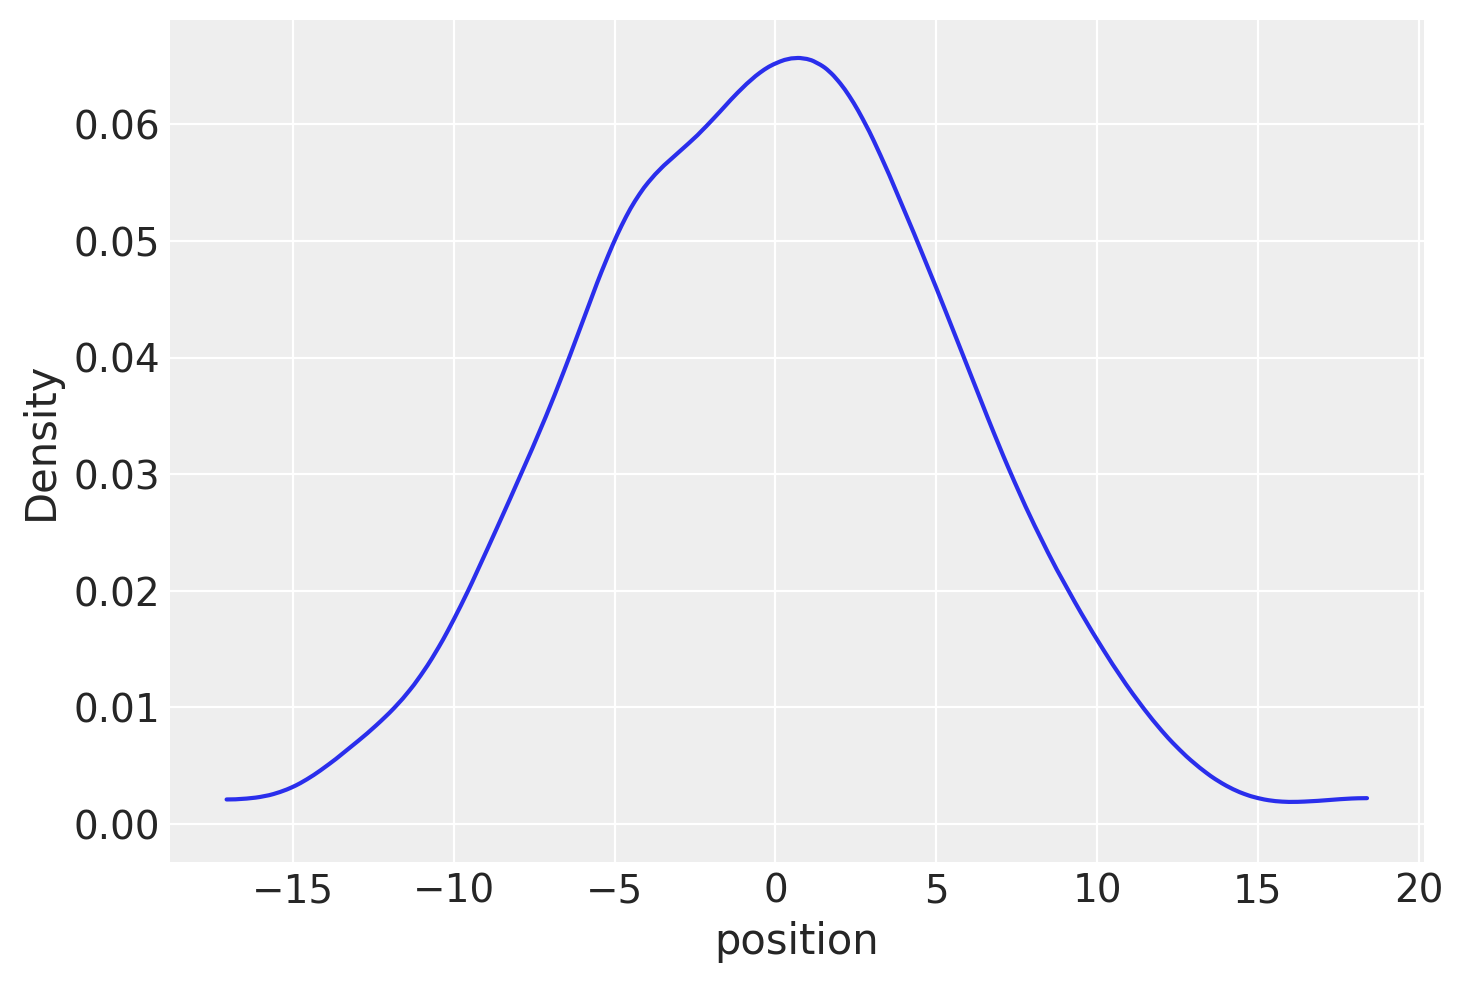

In [5]:
pos = np.random.uniform(-1, 1, size=(steps, repetitions)).sum(0)
az.plot_kde(pos)
plt.xlabel("position")
plt.ylabel("Density");

In [ ]:
pos.shape

(1000,)

#### Code 4.2 and 4.3

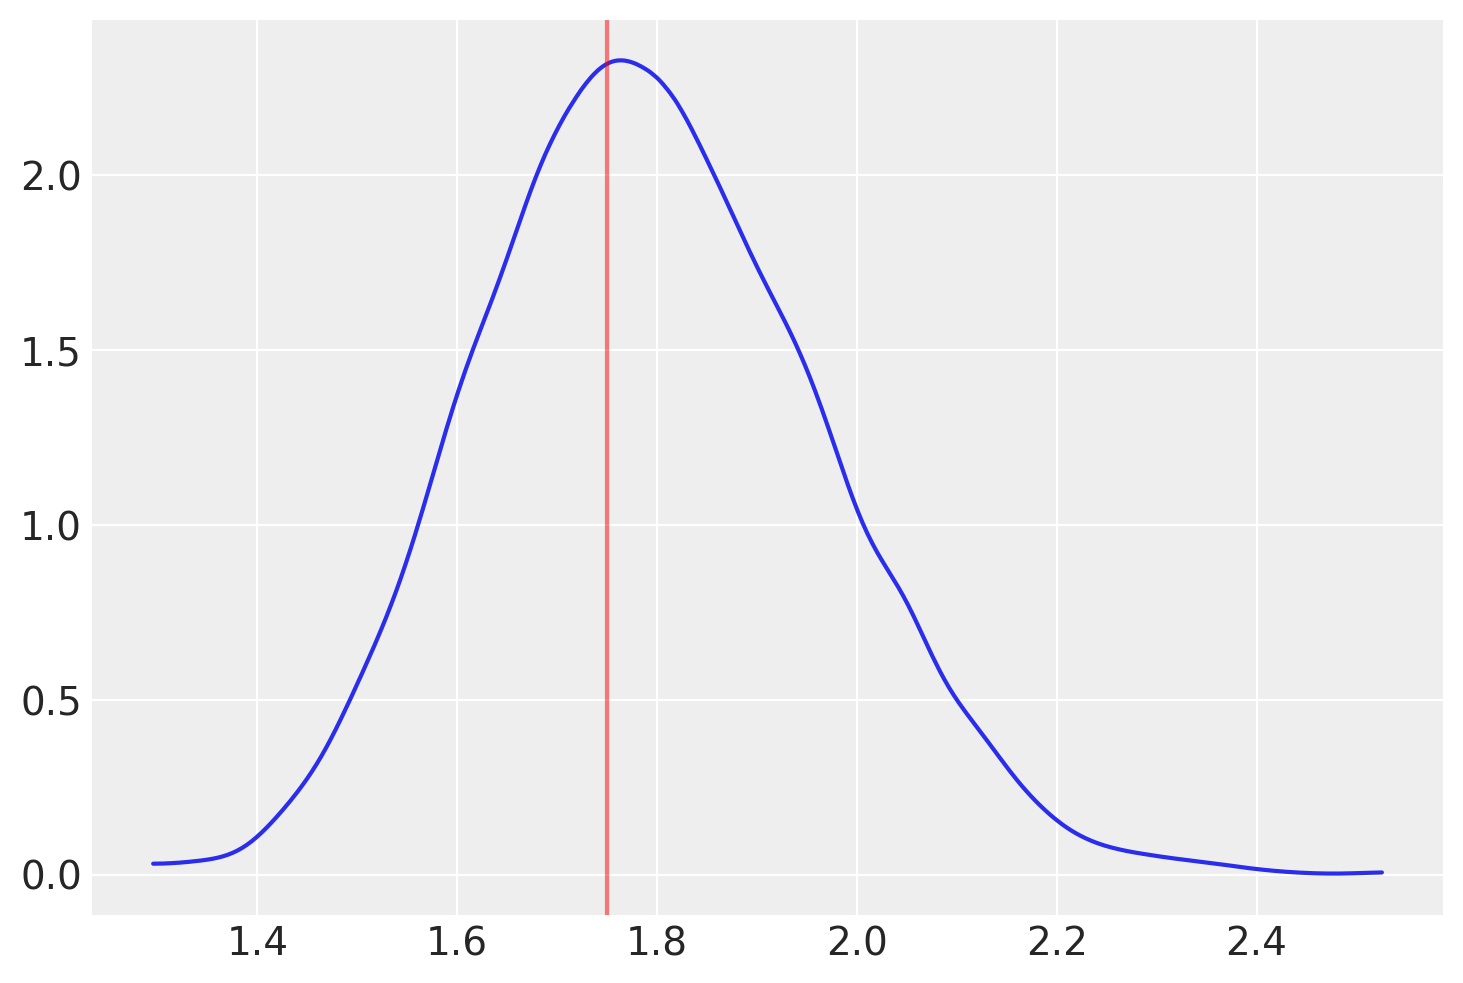

In [6]:
pos = np.random.uniform(1, 1.1, size=(12, 10000)).prod(0)
az.plot_kde(pos);
plt.axvline(1.75, c ='r', alpha = 0.5)


#### Code 4.4
The comparision is betweeen multiplication with small fluctuations and large fluctuations.

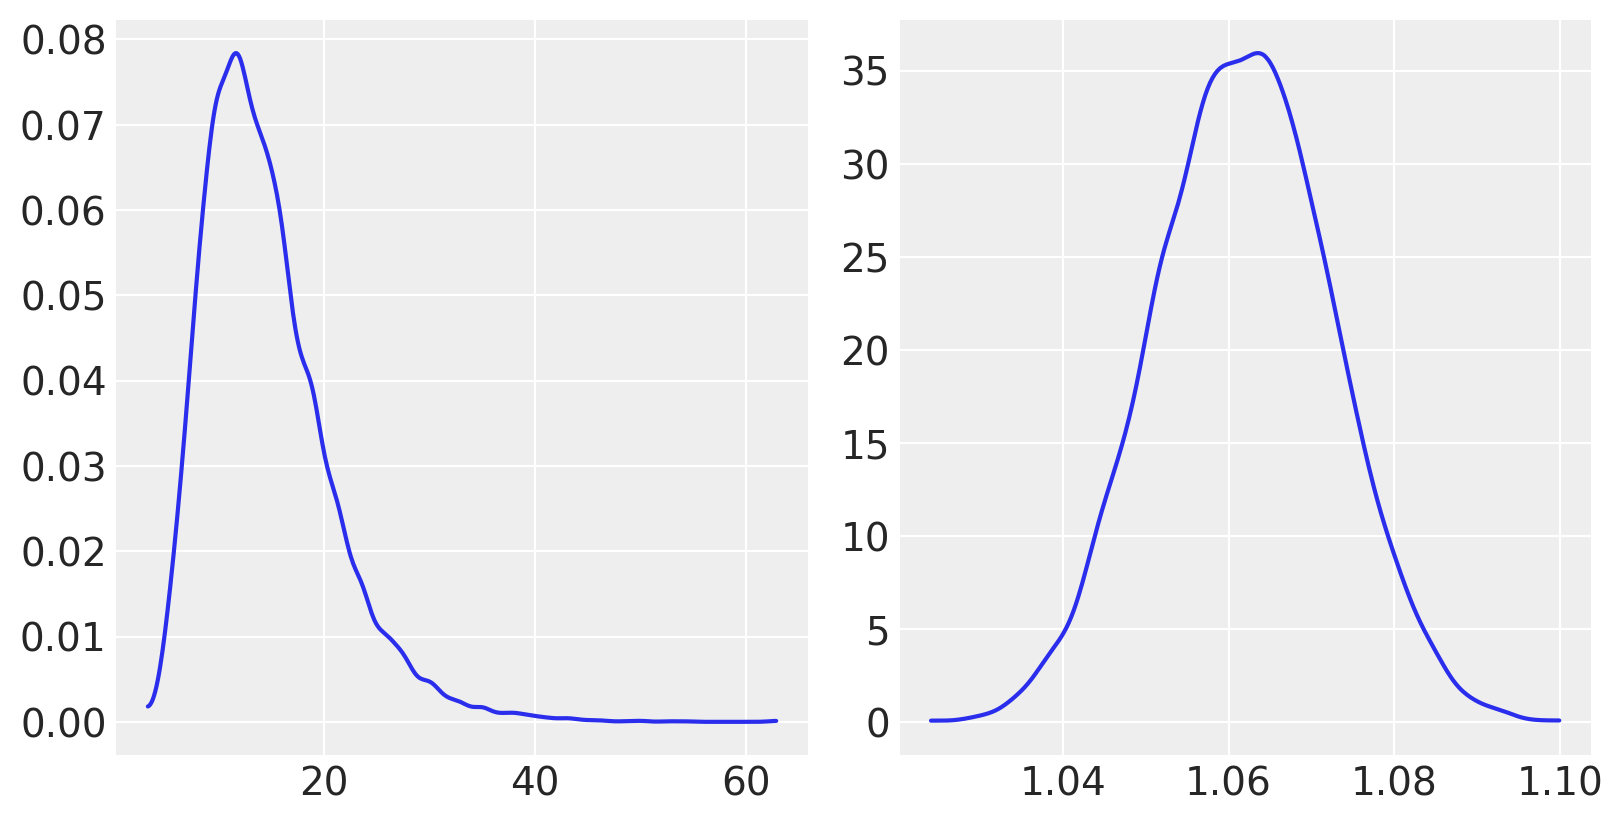

In [7]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1]);

In [ ]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))

#### Code 4.5
Product of large fluctuations in log scale

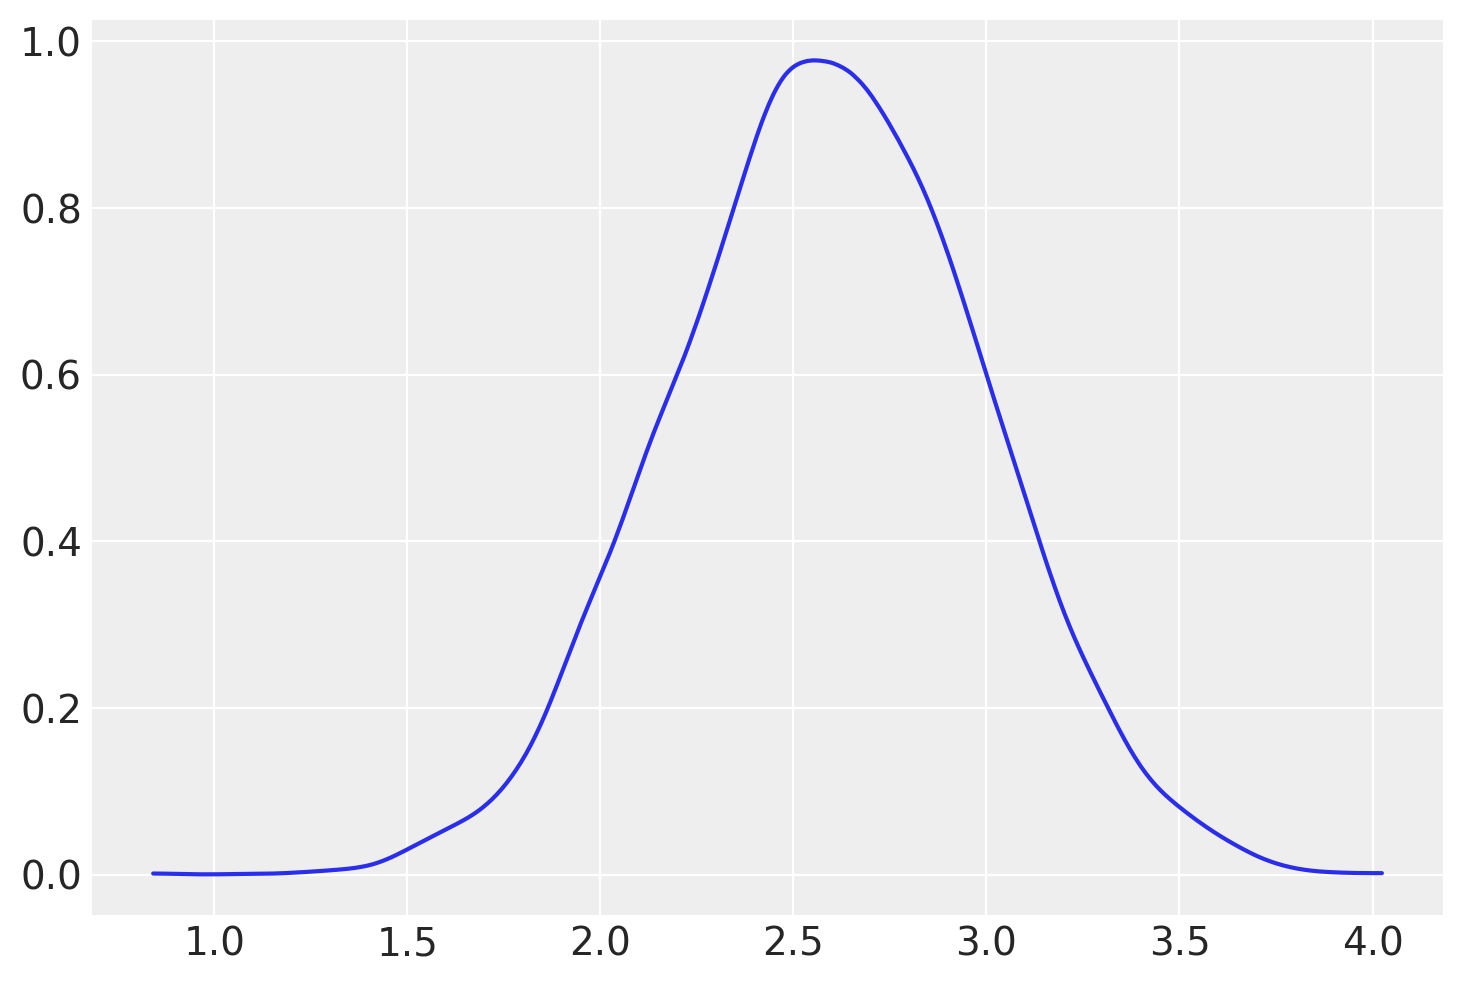

In [9]:
nums = np.random.uniform(1, 1.5, size=(12, 10000))

#log_big0 = np.log( nums).sum(0)
log_big1 = np.log(nums.prod(0))
#az.plot_kde(log_big0);
az.plot_kde(log_big1);

#### Code 4.6

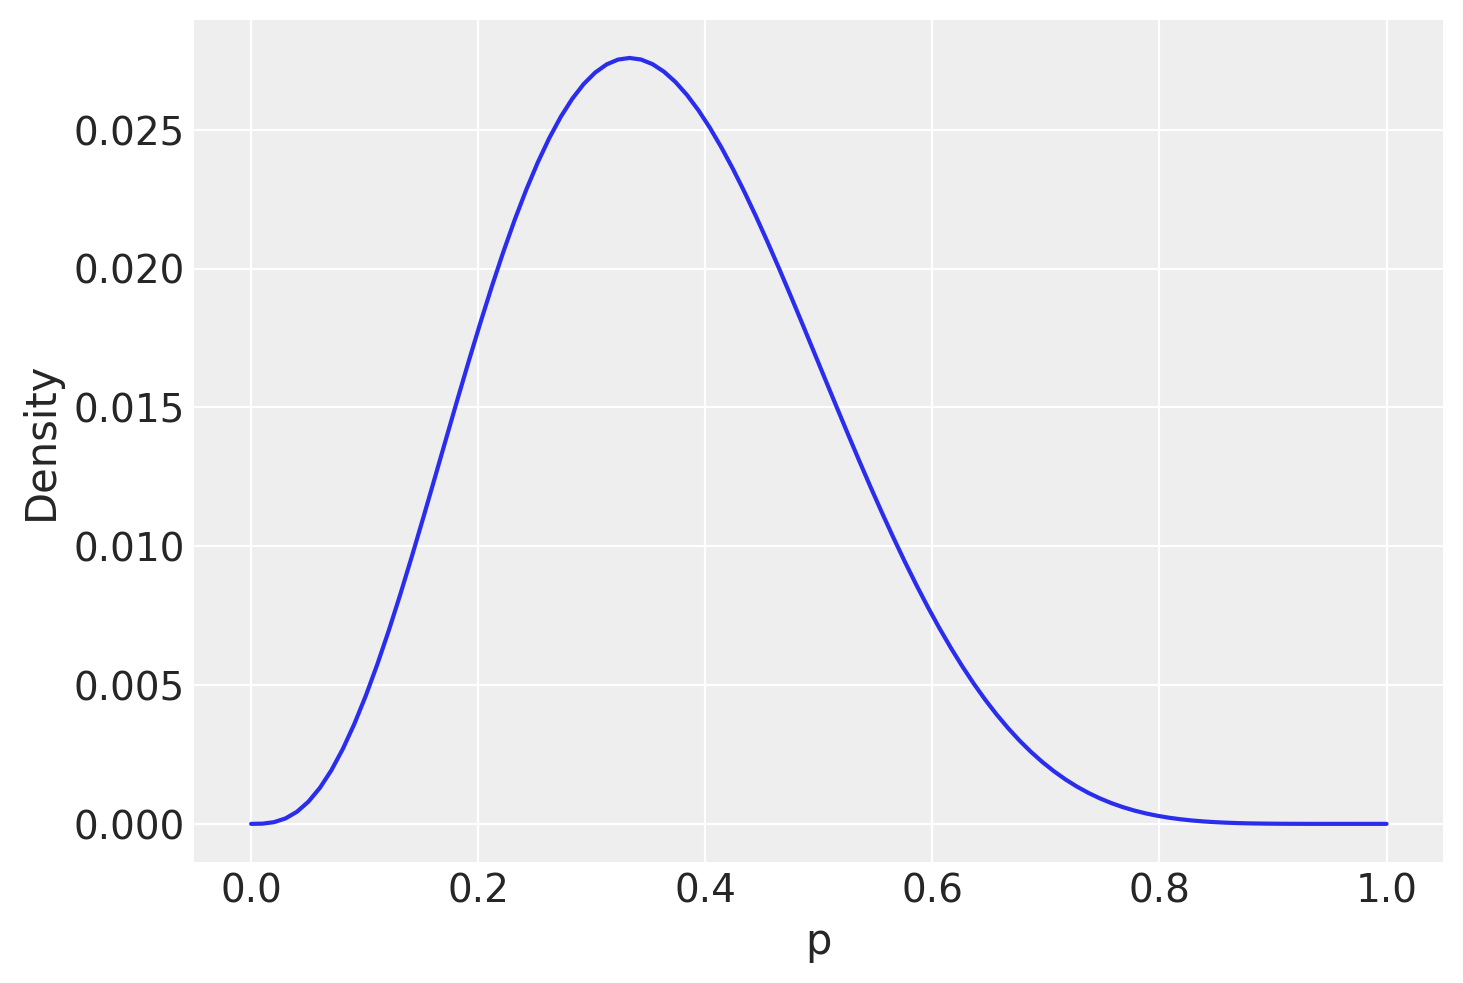

In [11]:
w, n = 3, 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior / (posterior).sum()
plt.plot(p_grid, posterior)
plt.xlabel("p")
plt.ylabel("Density");

#### Code 4.7 and 4.8

In [12]:
dat = pd.read_csv("https://raw.githubusercontent.com/vinayvamshirr/pymc-resources/main/Rethinking_2/Data/Howell1.csv", sep=";", header=0)
dat.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

In [13]:
dat.shape

(544, 4)

```pd.info()``` is similar or ```str(df)``` in **R**

In [14]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


#### Code 4.9
```pd.describe()``` is equivalent to R ```summary(df)```

In [15]:
dat.describe()

height      weight         age        male
count  544.000000  544.000000  544.000000  544.000000
mean   138.263596   35.610618   29.344393    0.472426
std     27.602448   14.719178   20.746888    0.499699
min     53.975000    4.252425    0.000000    0.000000
25%    125.095000   22.007717   12.000000    0.000000
50%    148.590000   40.057844   27.000000    0.000000
75%    157.480000   47.209005   43.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000

In [18]:
az.summary(dat.to_dict(orient="list"), kind="stats")

mean      sd  hdi_5.5%  hdi_94.5%
height  138.264  27.602    90.805    170.180
weight   35.611  14.719    11.368     55.707
age      29.344  20.747     0.000     57.000
male      0.472   0.500     0.000      1.000

#### Code 4.10

In [19]:
dat.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

#### Code 4.11 -  Extracting/Slicing and referencing columns
```df.column_name``` in python is equivlent to ```df$column_name``` in R

```df.iloc[]```



In [20]:
d2 = dat[dat.age >= 18]
d2['height'].count(), d2['height'].unique().shape[0]

(352, 81)

In [21]:
dat.iloc[1:4,0:2]

height     weight
1  139.700  36.485807
2  136.525  31.864838
3  156.845  53.041914

#### Code 4.12 - The Normal

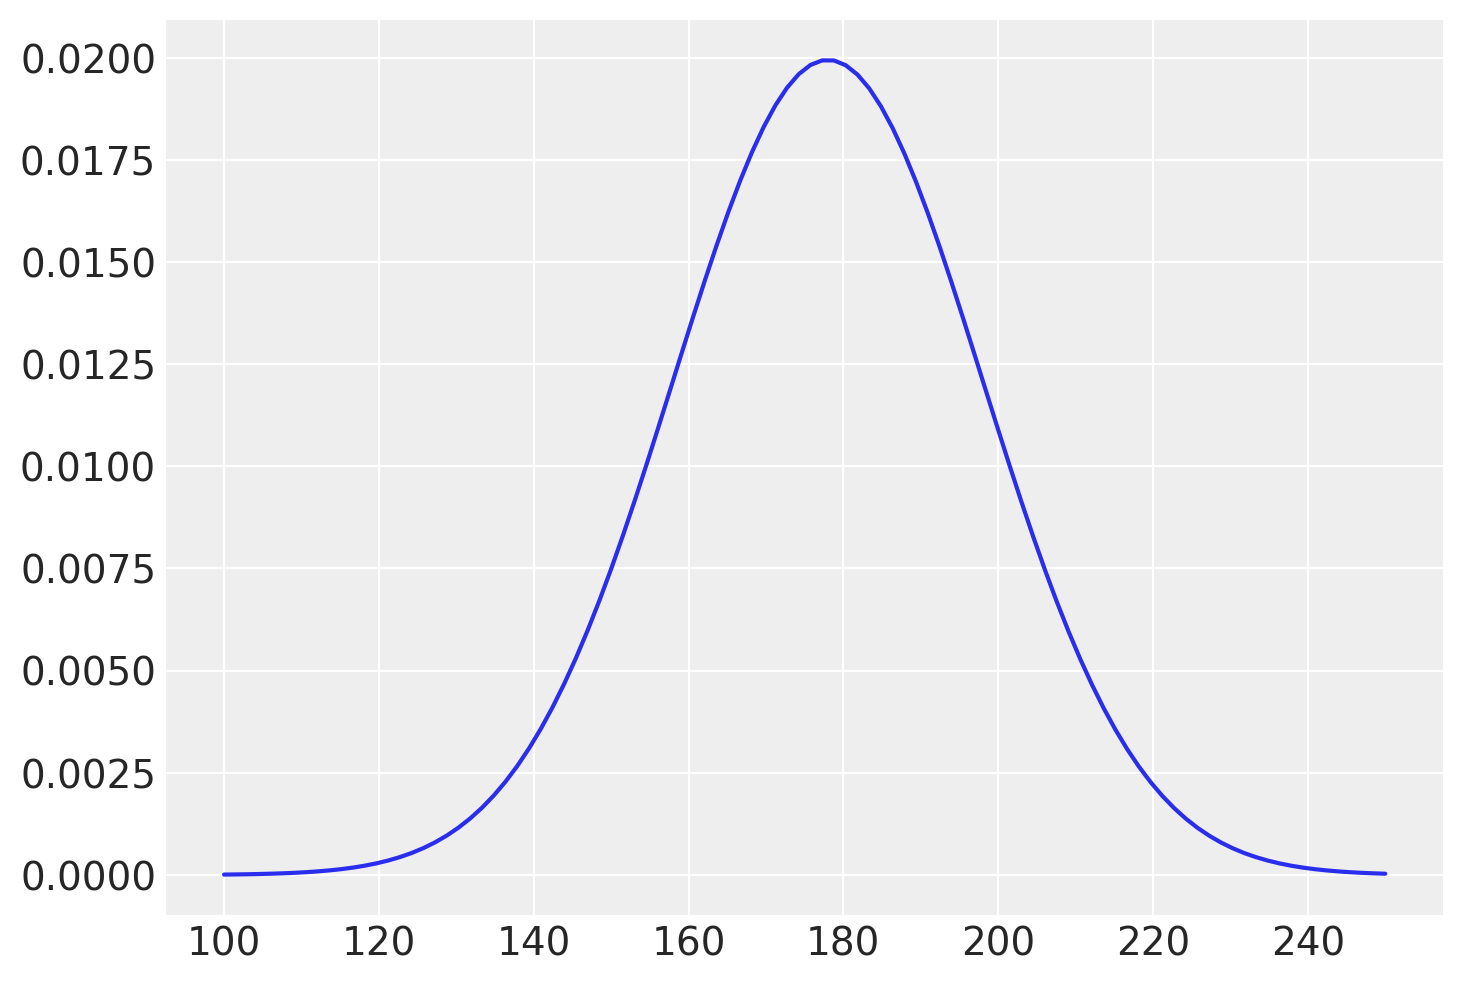

In [22]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20));

#### Code 4.13 The Uniform

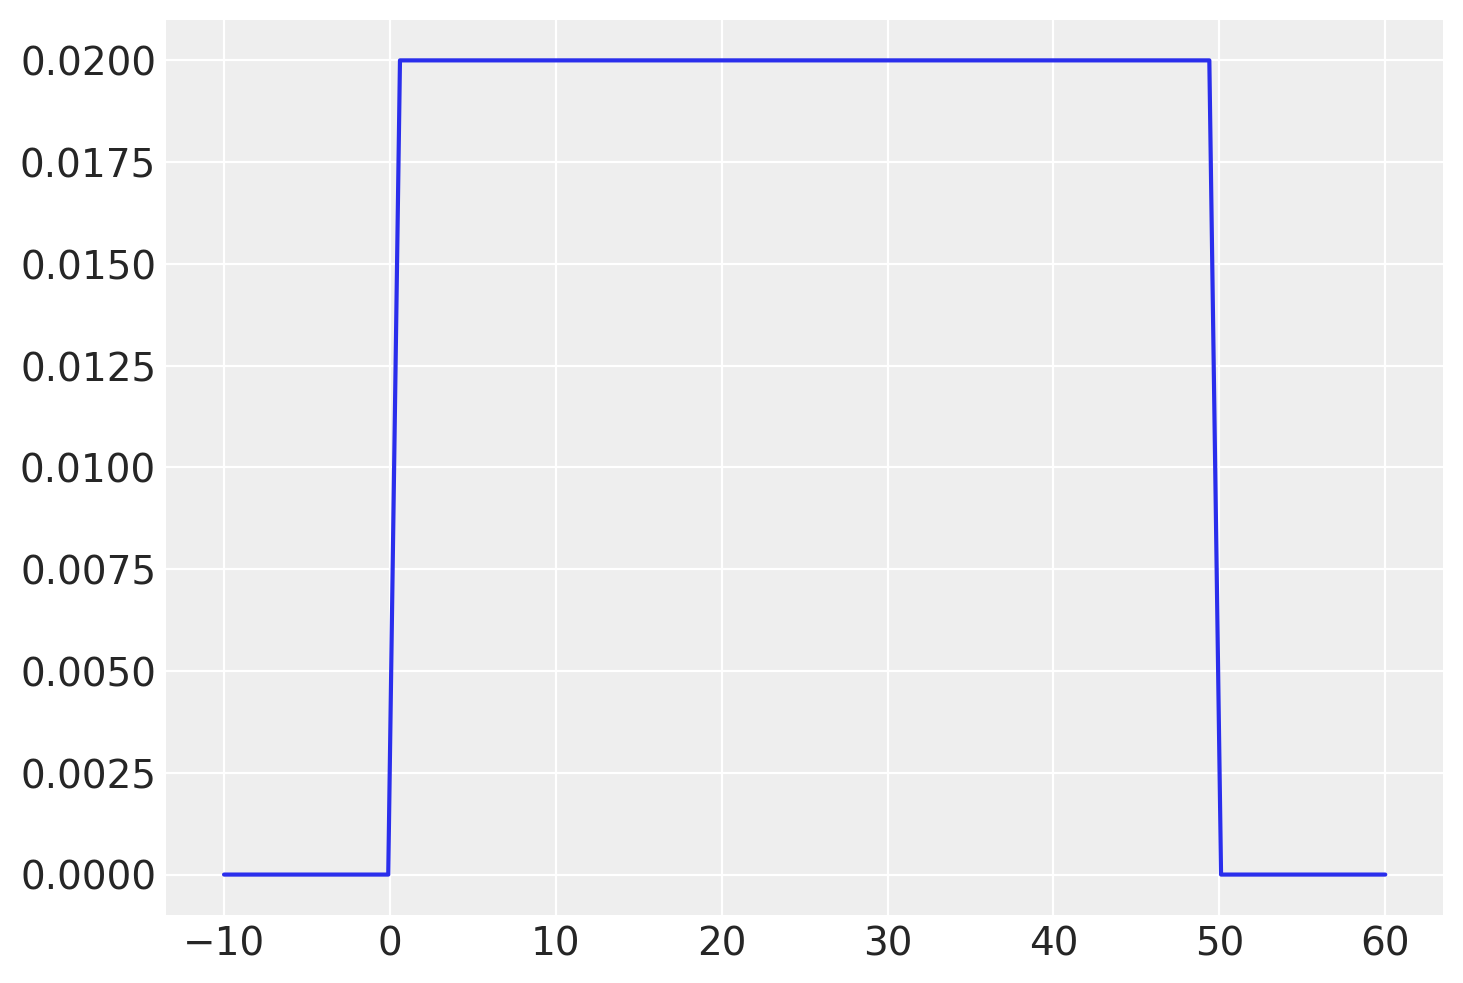

In [23]:
#@title Uniform
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

#### Code 4.14
Analysis of the Prior with different mean and variances

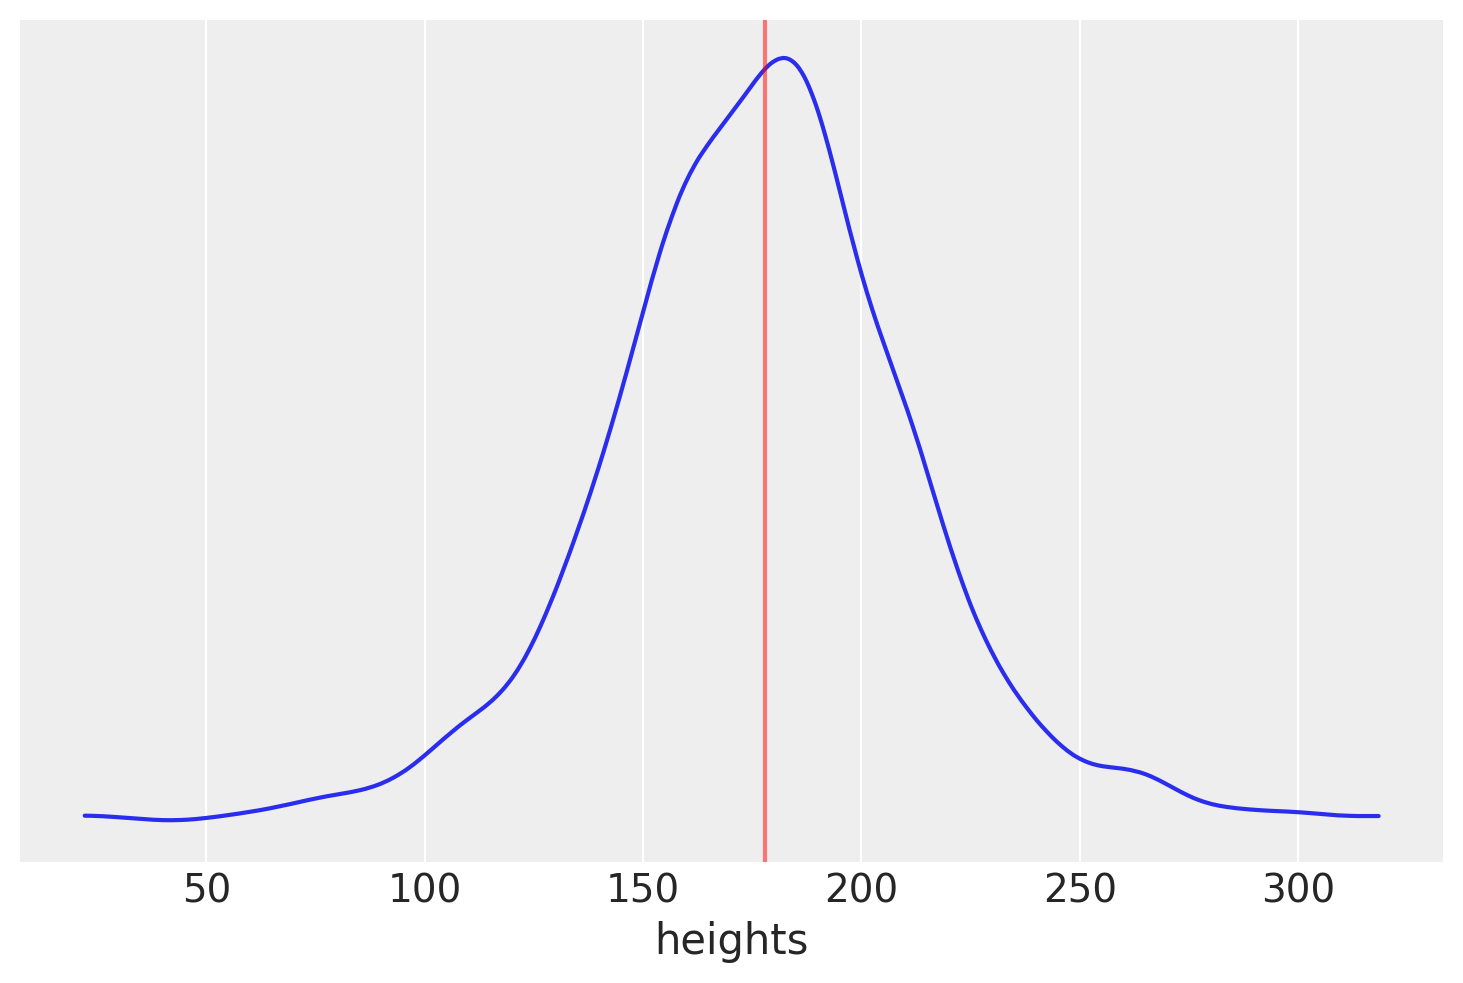

In [24]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel("heights")
plt.axvline(178, c='r', alpha = 0.5)
plt.yticks([]);

#### Code 4.15
An insensible prior , we have negative heights and giants, which are very rare

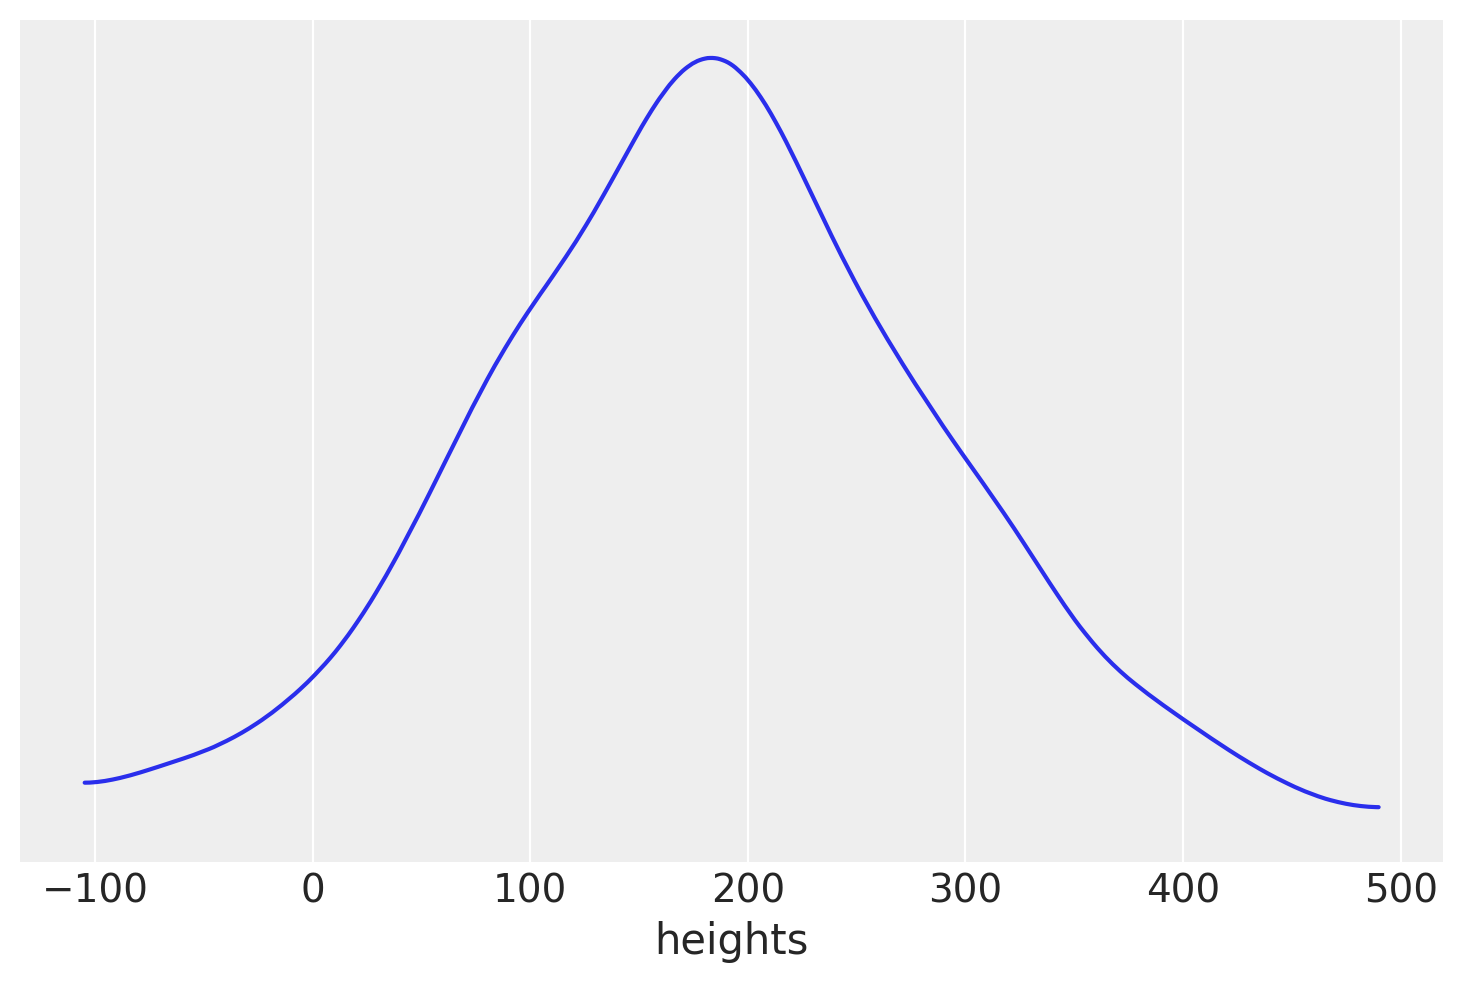

In [25]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=100, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel("heights")
plt.yticks([]);

#### Code 4.16
```np.mgrid()``` generates a mesh grid. In R this is done by ```expand.grid(vec1,vec2)```  
It returns two arrays in which cell value is either the x coordinate or the y coordinate.  
It is easier than having two loops.



In [28]:
post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T

# Sum of log likelihoods is the log likelihood of the data
# List comprehension for each point in the mesh grid
likelihood = [
    sum(stats.norm.logpdf(d2.height, loc=post[:, 0][i], scale=post[:, 1][i]))
    for i in range(len(post))
]

#Posterior probability is being calculated in the log scale hence the summation
post_prod = (
    likelihood
    + stats.norm.logpdf(post[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post[:, 1], loc=0, scale=50)
)
post_prob = np.exp(post_prod - max(post_prod))

In [34]:
te = stats.norm.logpdf(d2.height, loc=post[:, 0][1], scale=post[:, 1][1])
sum(te)
post.shape



list

#### Code 4.17

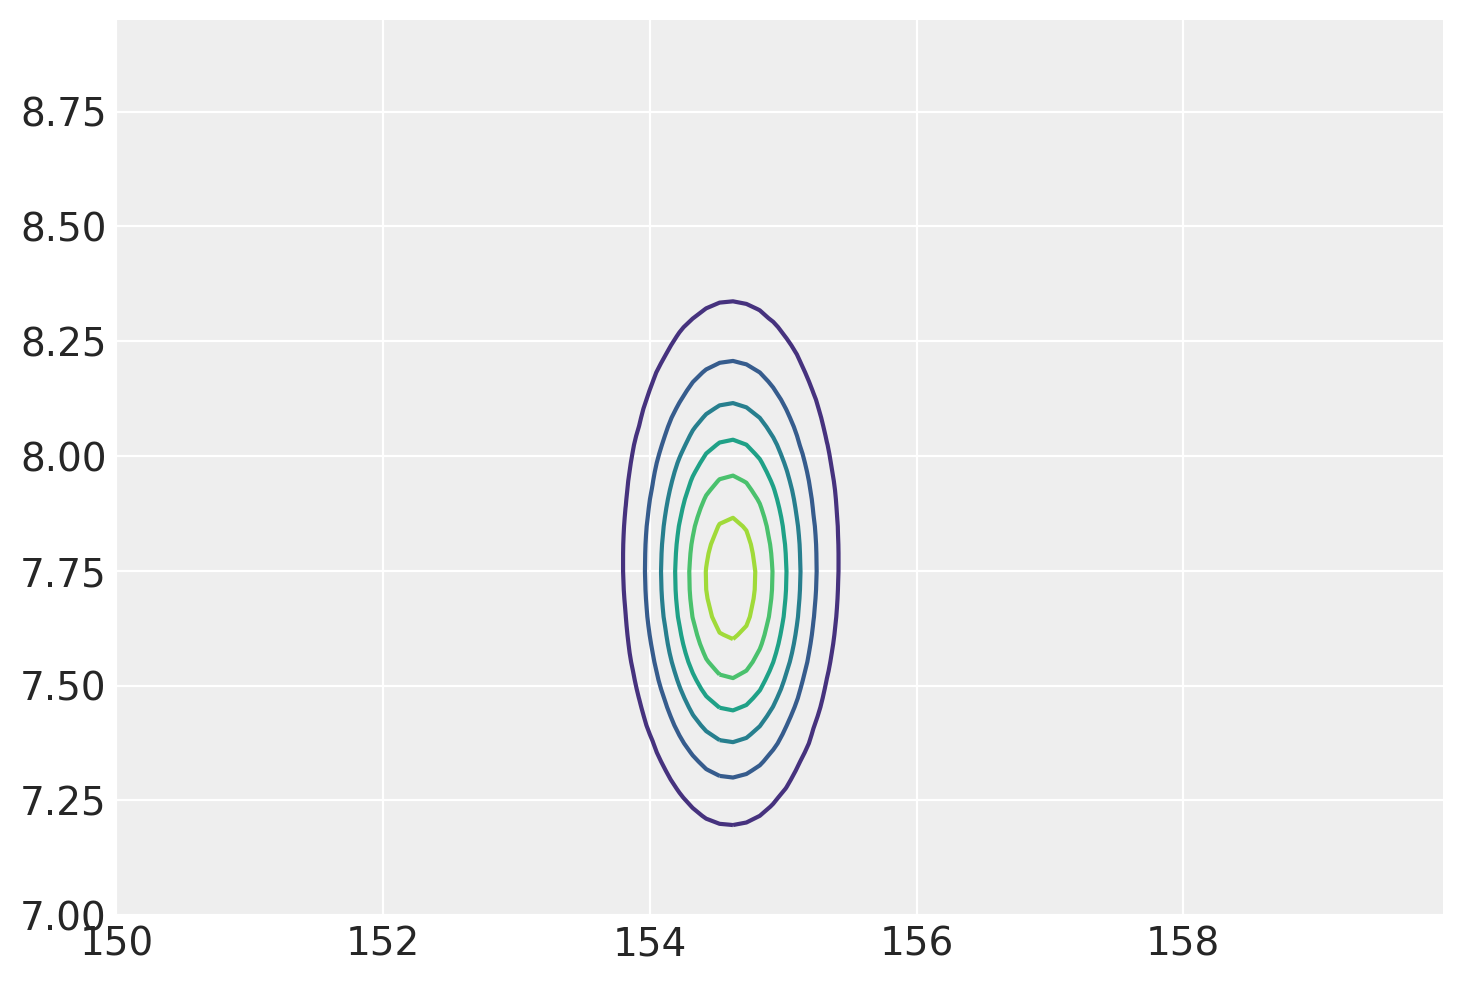

In [35]:
xi = np.linspace(post[:, 0].min(), post[:, 0].max(), 100)
yi = np.linspace(post[:, 1].min(), post[:, 1].max(), 100)
zi = griddata((post[:, 0], post[:, 1]), post_prob, (xi[None, :], yi[:, None]))

plt.contour(xi, yi, zi);

#### Code 4.18

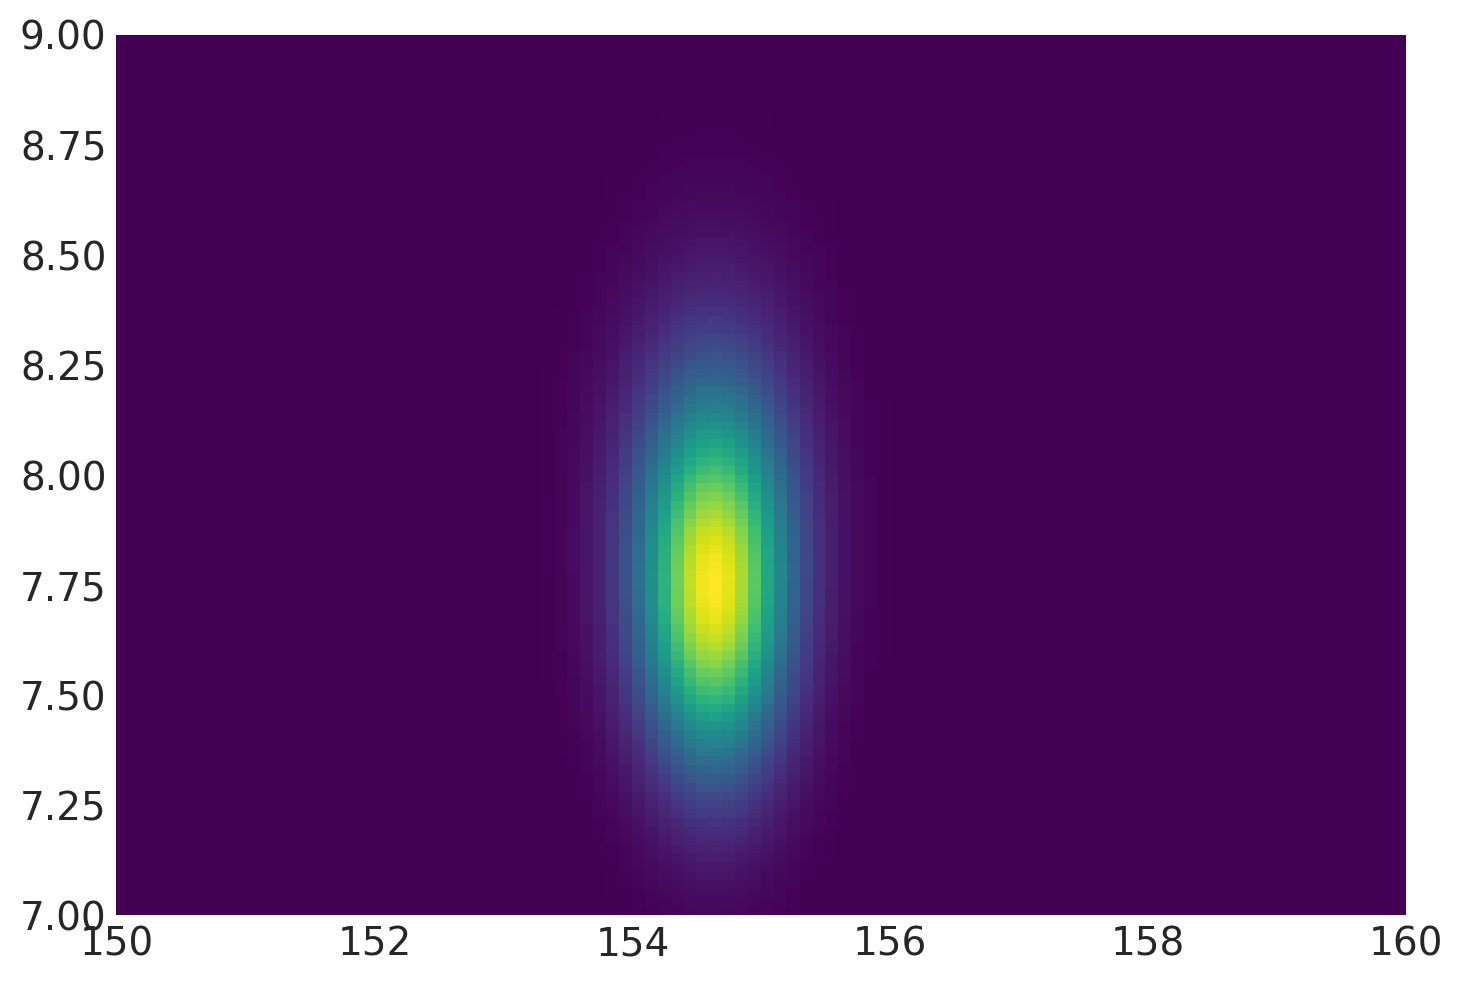

In [36]:
_, ax = plt.subplots()
ax.imshow(zi, origin="lower", extent=[150.0, 160.0, 7.0, 9.0], aspect="auto")
ax.grid(False)

#### Code 4.19 and 4.20

Posterior sampling

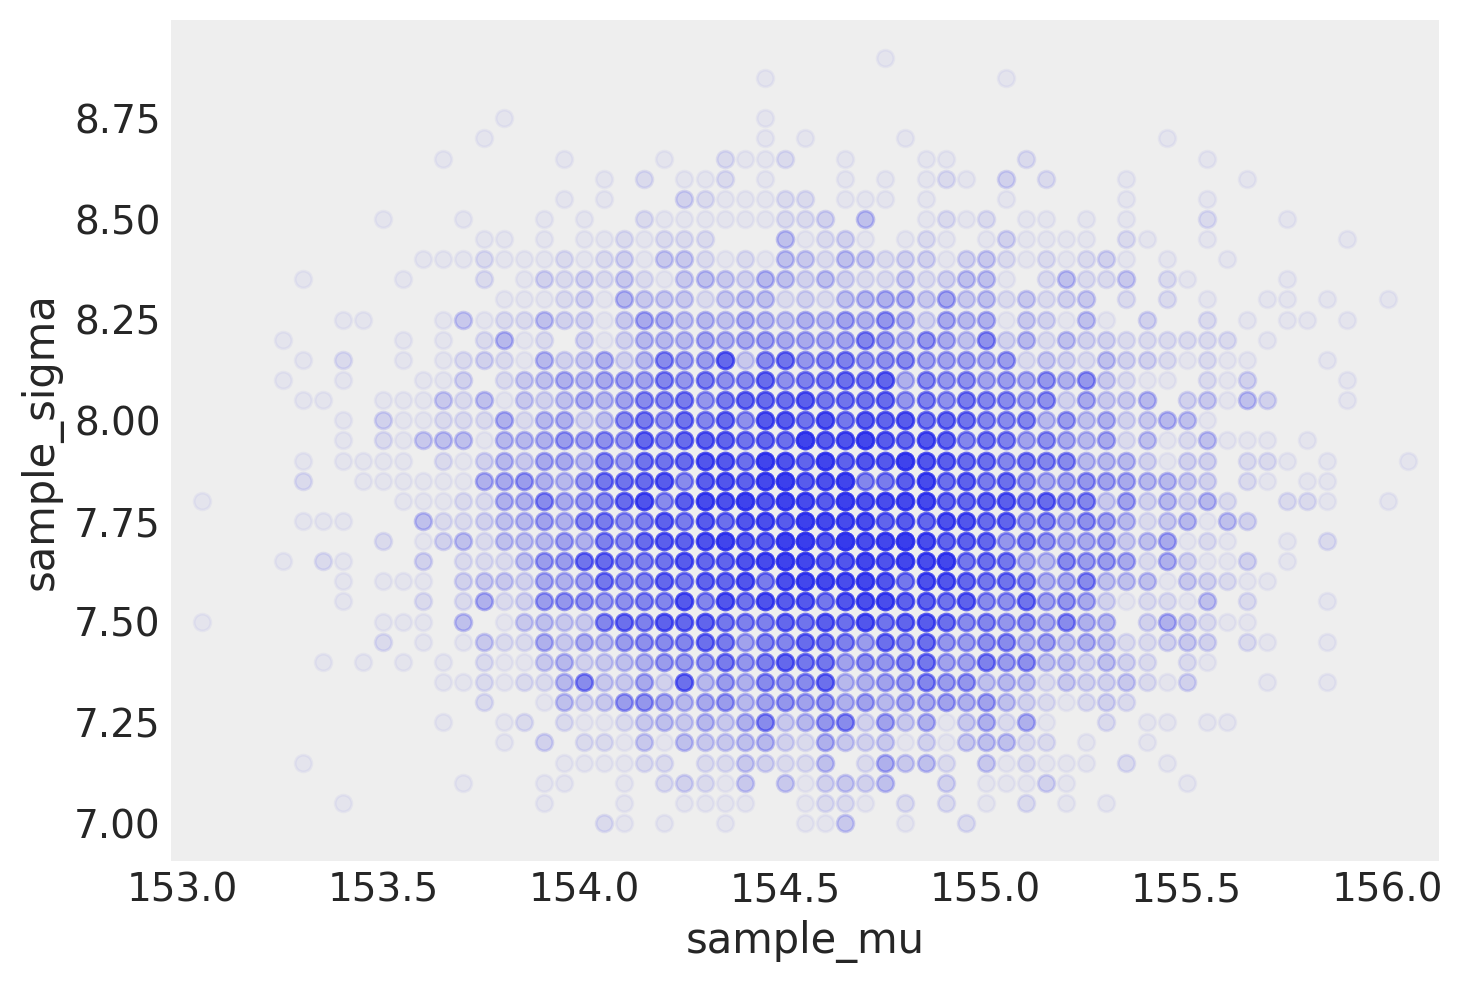

In [37]:
#Random sampling with replacement
sample_rows = np.random.choice(
    np.arange(len(post)), size=10000, replace=True, p=(post_prob / post_prob.sum())
)
#Indexing by array
sample_mu = post[:, 0][sample_rows]
sample_sigma = post[:, 1][sample_rows]

plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)
plt.axis("equal")
plt.grid(False)
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma");

In [53]:
post[:,0][[1,84]]

array([150. , 150.1])

#### Code 4.21

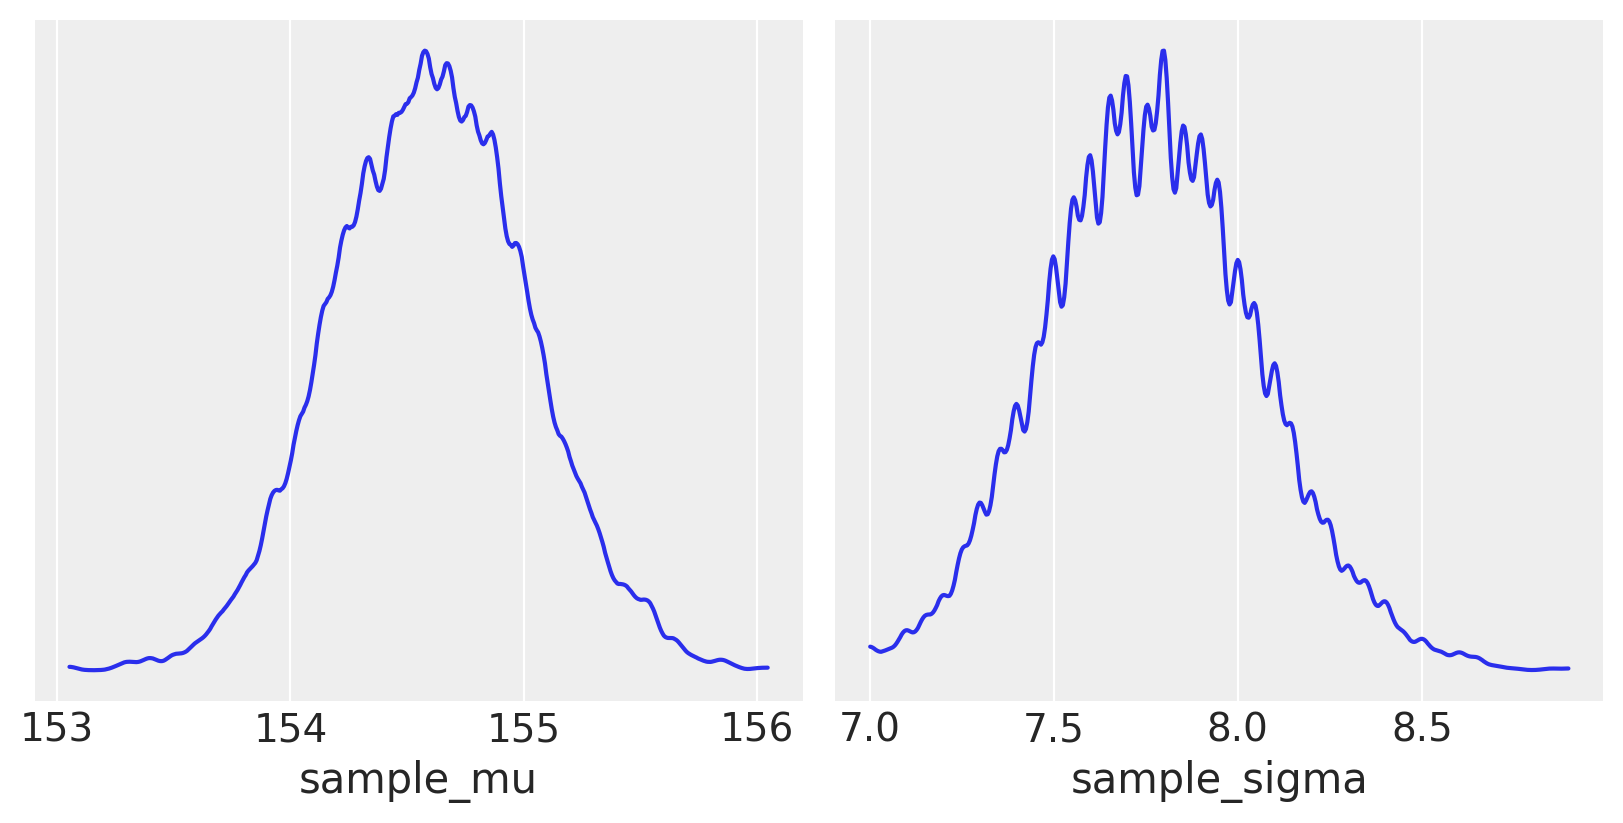

In [54]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(sample_mu, ax=ax[0])
ax[0].set_xlabel("sample_mu")
ax[0].set_yticks([])
az.plot_kde(sample_sigma, ax=ax[1])
ax[1].set_xlabel("sample_sigma")
ax[1].set_yticks([]);

#### Code 4.22

In [ ]:
az.hdi(sample_mu), az.hdi(sample_sigma)

(array([  8.57857317, 337.1225047 ]), array([ 0.13069147, 44.27974444]))

#### Code 4.23 and  4.24
Using a different prior and a smaller sample of the data

In [55]:
d3 = np.random.choice(d2.height, 20)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2, -1).T

likelihood2 = [
    sum(stats.norm.logpdf(d3, loc=post2[:, 0][i], scale=post2[:, 1][i])) for i in range(len(post2))
]

post_prod2 = (
    likelihood2
    + stats.norm.logpdf(post2[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post2[:, 1], loc=0, scale=50)
)

post_prob2 = np.exp(post_prod2 - max(post_prod2))

sample_rows2 = np.random.choice(
    np.arange(len(post2)), size=10000, replace=True, p=(post_prob2 / post_prob2.sum())
)
sample_mu2 = post2[:, 0][sample_rows2]
sample_sigma2 = post2[:, 1][sample_rows2]

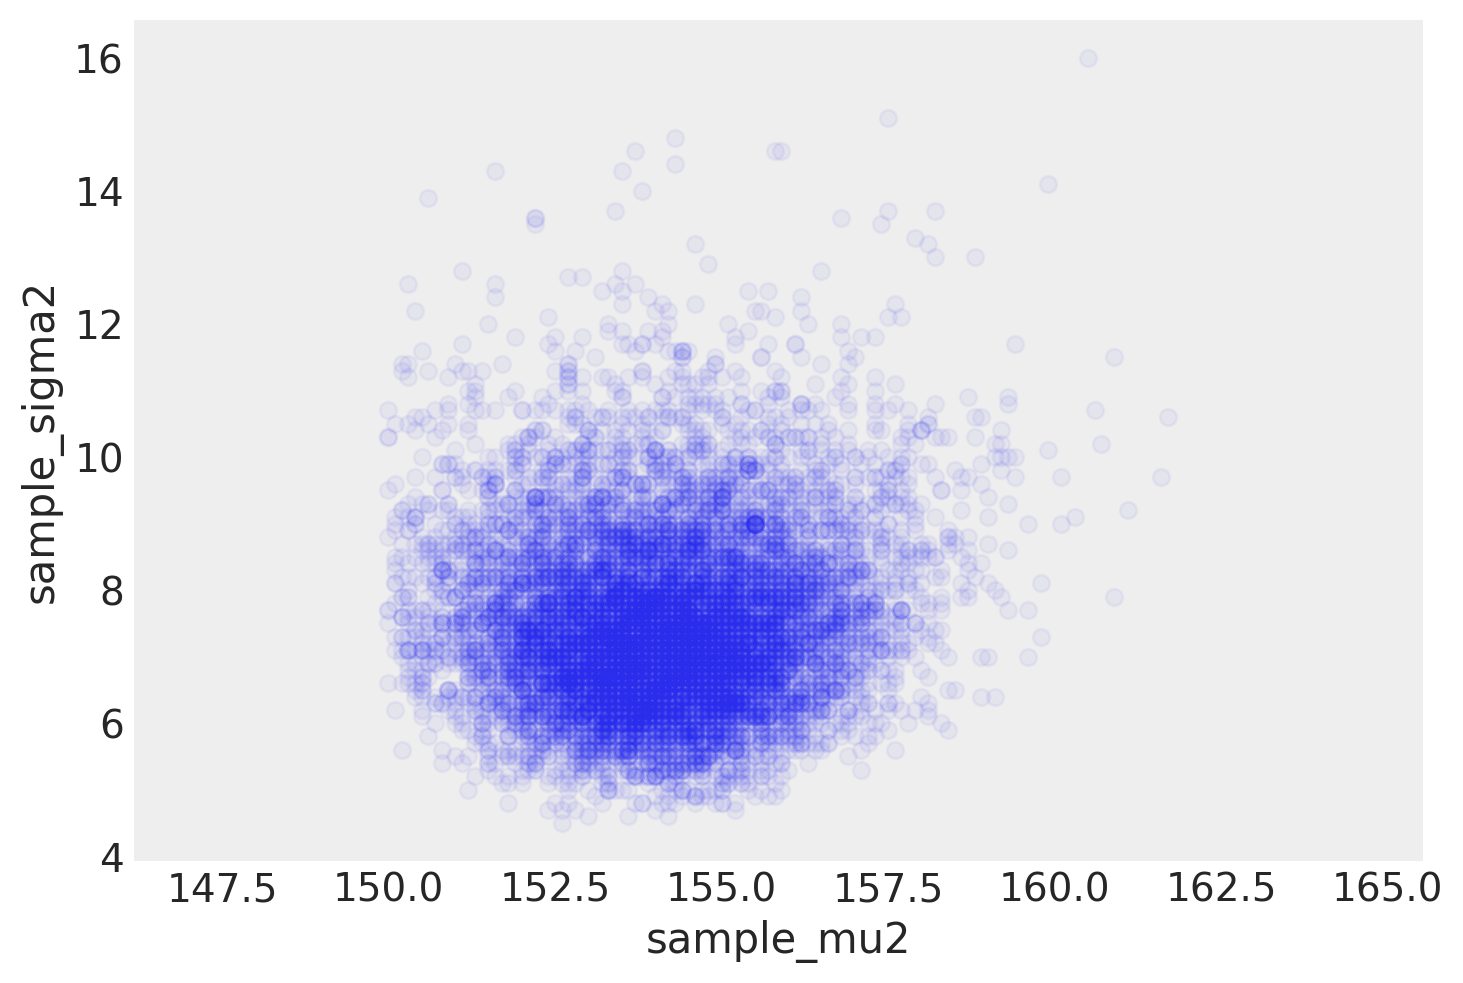

In [56]:
plt.plot(sample_mu2, sample_sigma2, "o", alpha=0.05)
plt.axis("equal")
plt.xlabel("sample_mu2")
plt.ylabel("sample_sigma2")
plt.grid(False);

#### Code 4.25

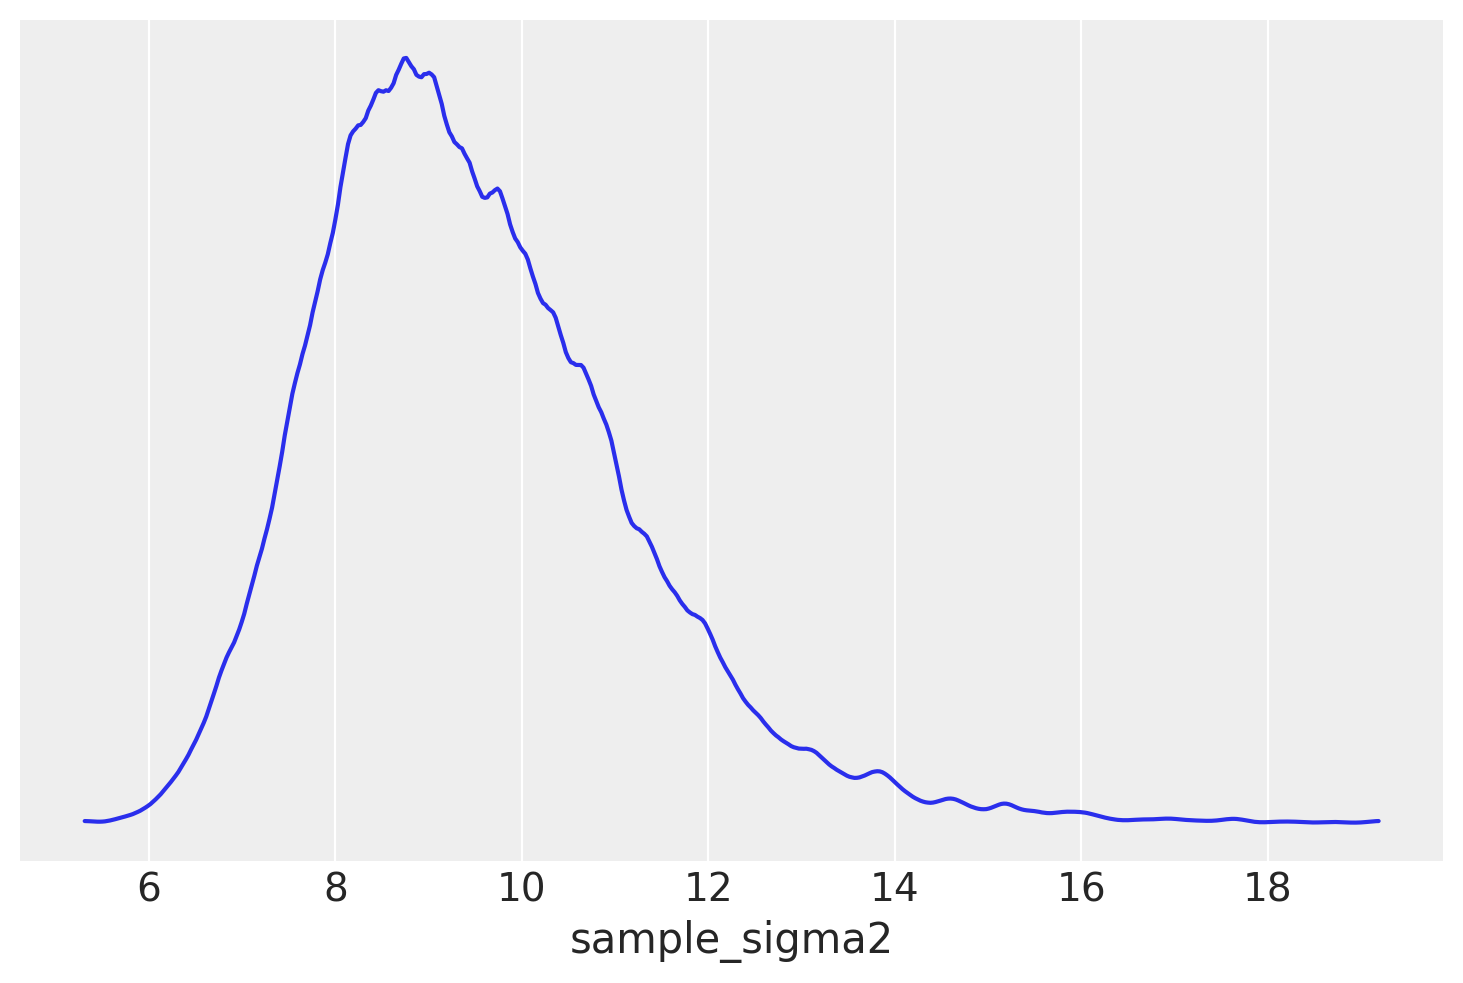

In [ ]:
az.plot_kde(sample_sigma2)
plt.xlabel("sample_sigma2")
plt.yticks([]);

#### Code 4.26

We are repeating code 4.7, 4.8 and 4.10, But using pyMC3

In [58]:
d = pd.read_csv("https://raw.githubusercontent.com/vinayvamshirr/pymc-resources/main/Rethinking_2/Data/Howell1.csv", sep=";", header=0)
d2 = d[d.age >= 18]

#### Code 4.27

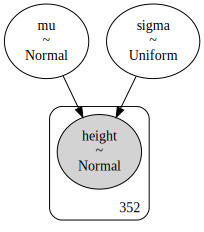

In [59]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)

pm.model_to_graphviz(m4_1)

#### Code 4.28

We could use a quadratic approximation like McElreath does in his book and we did in code 2.6. But Using PyMC is really simple to just sample from the model using a "sampler method". Most common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family (for details read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

PyMC comes with various samplers. Some samplers are more suited than others for certain type of variable (and/or problems). For now we are going to let PyMC choose the sampler for us. PyMC also tries to provide a reasonable starting point for the simulation. By default PyMC uses the same adaptive procedure as in STAN `'jitter+adapt_diag'`, which starts with a identity mass matrix and then adapts a diagonal based on the variance of the tuning samples. 

You can read more details of PyMC [here](http://pymc-devs.github.io/pymc/notebooks/getting_started.html)

In [61]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f660ba0a510>,
      dtype=object)

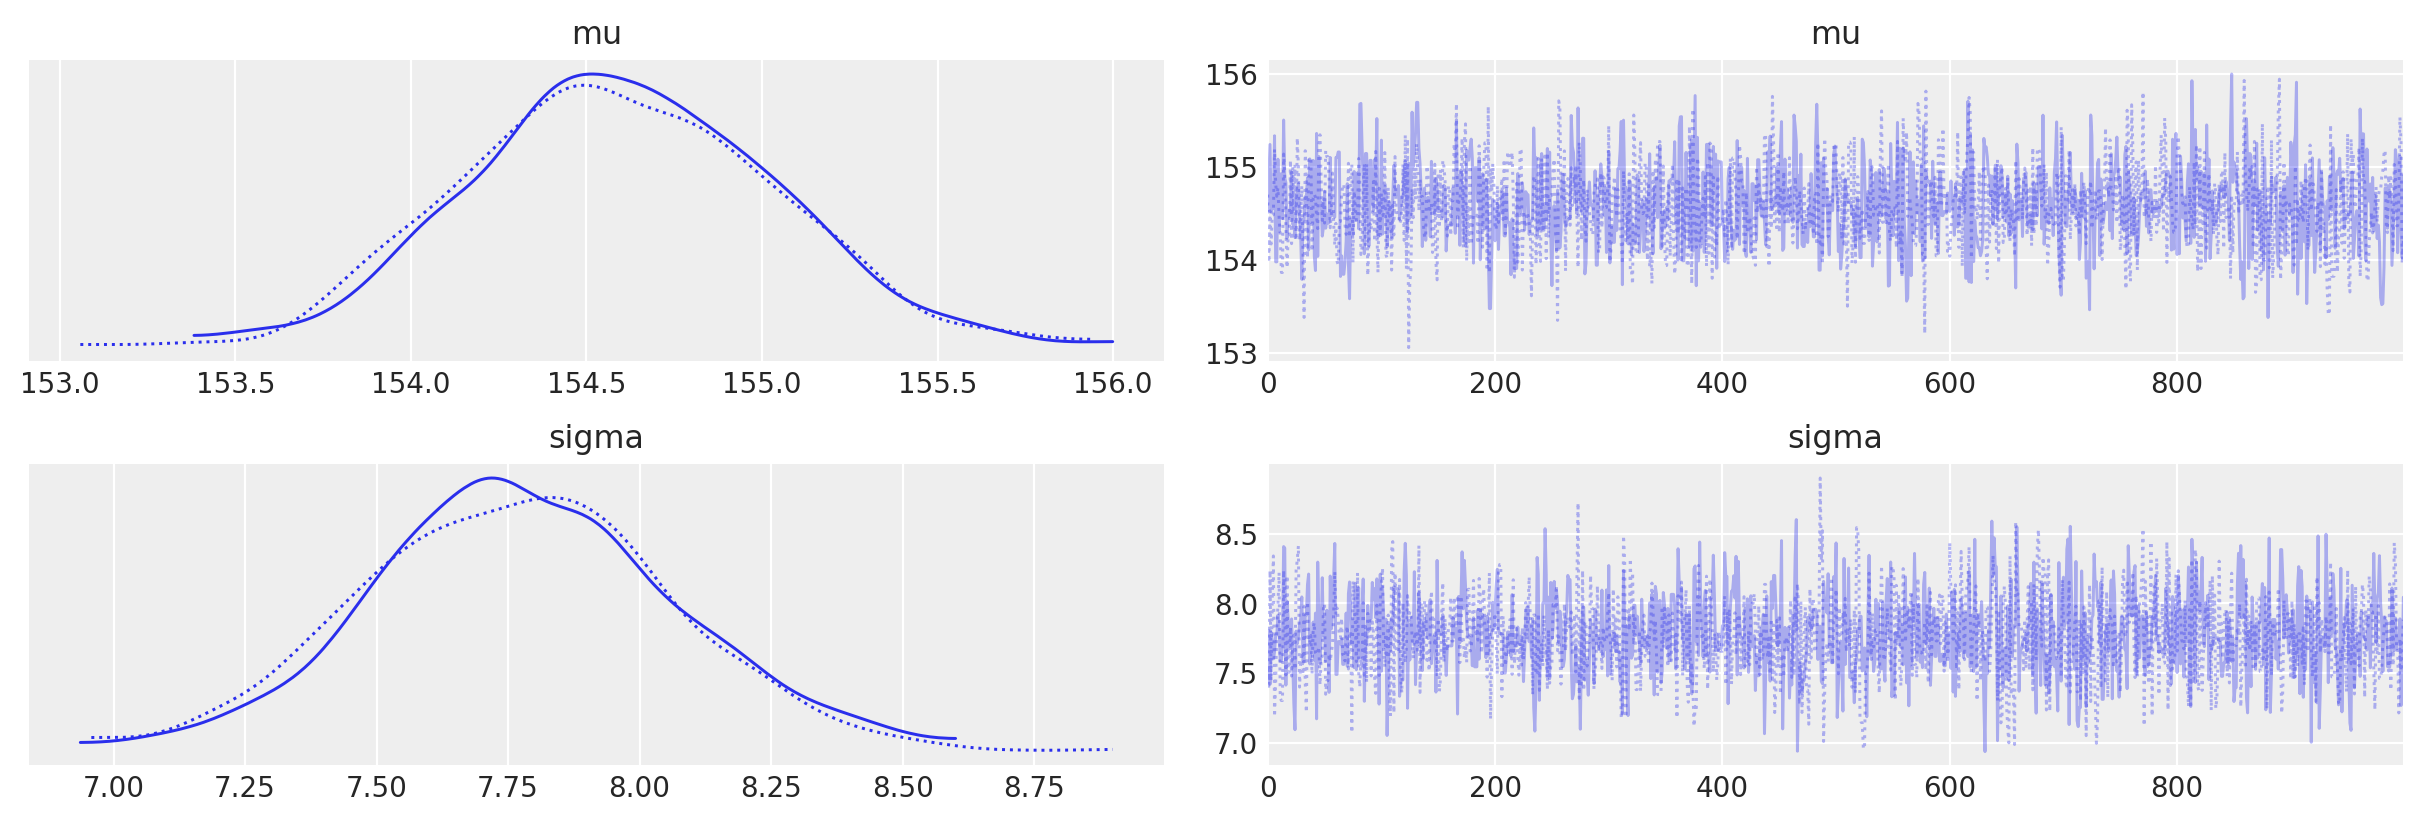

In [62]:
az.plot_trace(trace_4_1)
# this function lets you check the samples values

#### Code 4.29

In [63]:
az.summary(trace_4_1, round_to=2, kind="stats")

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean    sd  hdi_5.5%  hdi_94.5%
mu     154.60  0.43    153.92     155.28
sigma    7.77  0.29      7.32       8.24

#### Code 4.30

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


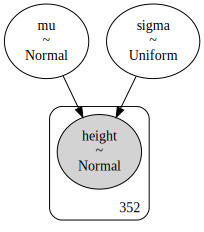

In [64]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)

pm.model_to_graphviz(m4_1)


#### Code 4.31

In [65]:
with pm.Model() as m4_2:
    mu = pm.Normal("mu", mu=178, sd=0.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_2 = pm.sample(1000, tune=1000)
az.summary(trace_4_2, round_to=2, kind="stats")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean    sd  hdi_5.5%  hdi_94.5%
mu     177.86  0.10    177.69     178.01
sigma   24.60  0.94     23.04      26.08

#### Code 4.32

For some computations could be nice to have the trace turned into a DataFrame, this can be done using the `trace_to_dataframe` function

In [ ]:
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

mu     sigma
mu     0.160692 -0.004405
sigma -0.004405  0.086026

#### Code 4.33

In [ ]:
np.diag(trace_df.cov())

array([0.16069231, 0.08602554])

In [ ]:
trace_df.corr()

mu     sigma
mu     1.000000 -0.037462
sigma -0.037462  1.000000

#### Code 4.34

We did not use the quadratic approximation, instead we use a MCMC method to sample from the posterior. Thus, we already have samples. We can do something like

In [ ]:
trace_df.head()

mu     sigma
0  154.099385  7.858097
1  154.099385  7.858097
2  154.927151  7.409640
3  154.462657  7.626823
4  154.462657  7.626823

Or directly from the trace (we are getting the first ten samples of _sigma_)

In [ ]:
trace_4_1["sigma"][:10]

array([7.85809685, 7.85809685, 7.40963992, 7.62682334, 7.62682334,
       7.62682334, 7.62682334, 7.7403118 , 7.68353468, 7.65879977])

#### Code 4.35

In our case, this is the same we did in the code 4.27

In [ ]:
az.summary(trace_4_1, round_to=2, kind="stats")

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean    sd  hdi_5.5%  hdi_94.5%
mu     154.60  0.40    153.96     155.23
sigma    7.77  0.29      7.29       8.22

#### Code 4.36

In [ ]:
stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(), size=10)

array([[154.92997909,   7.57585233],
       [155.52843323,   7.54949292],
       [154.24517661,   7.51725809],
       [153.89668968,   7.43501906],
       [154.81265766,   7.67629557],
       [154.54863326,   7.56658616],
       [154.59964321,   7.05510364],
       [154.49708525,   7.55661721],
       [155.08229429,   7.70651557],
       [154.33654267,   7.65417419]])

#### Code 4.37

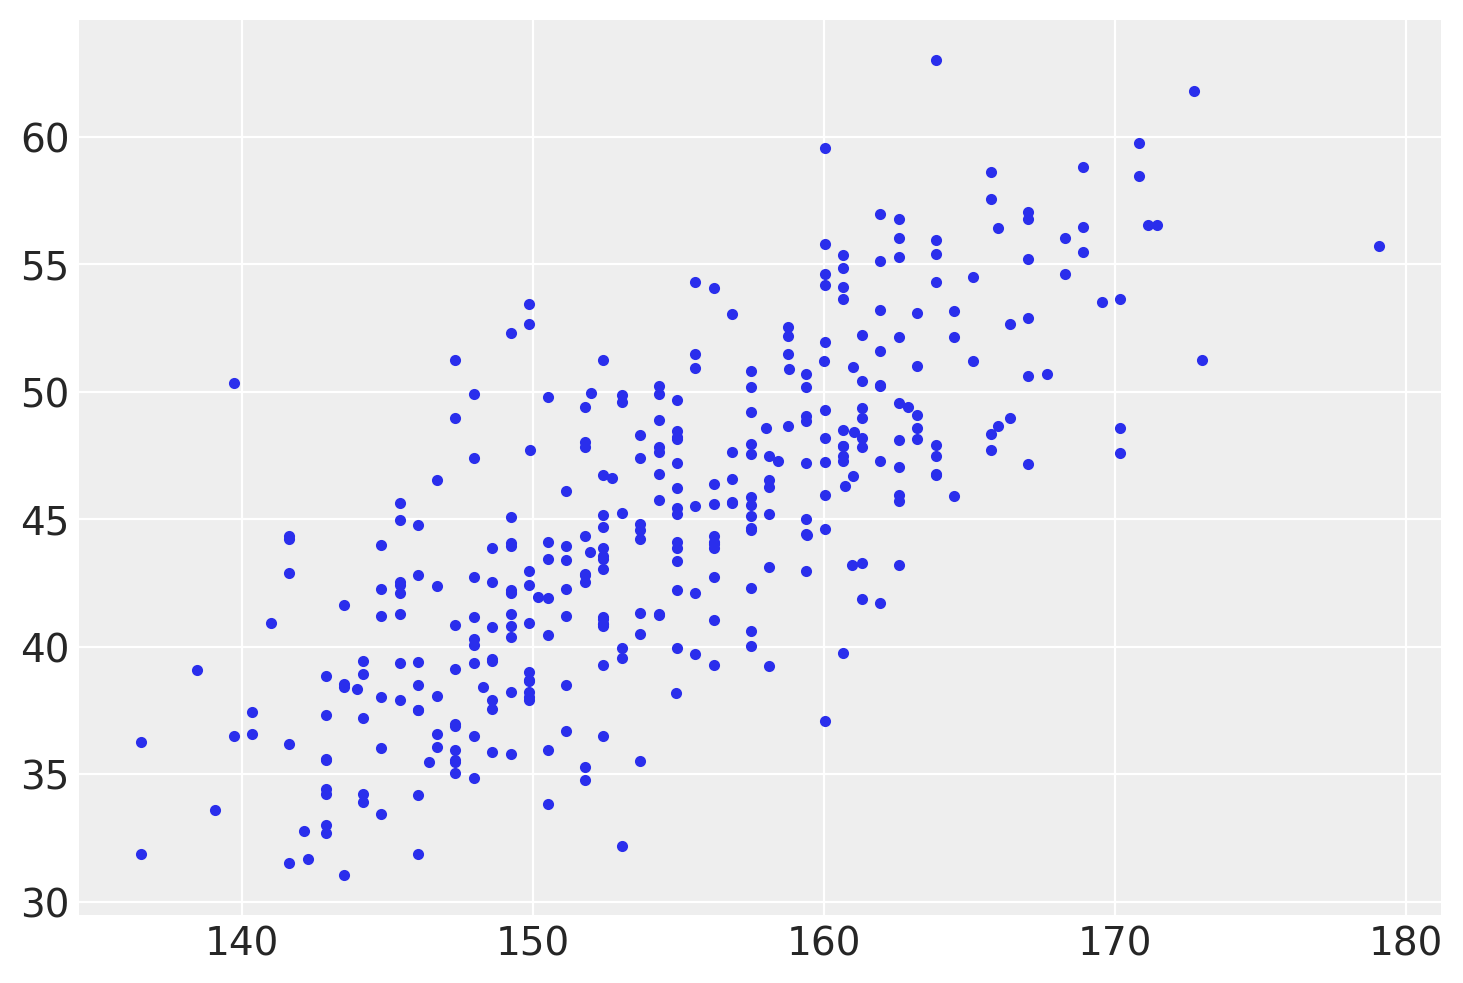

In [66]:
plt.plot(d2.height, d2.weight, ".");

#### Code 4.38

In [67]:
np.random.seed(2971)
N = 100  # 100 lines
a = stats.norm.rvs(178, 20, N)
b = stats.norm.rvs(0, 10, N)

#### Code 4.39 and 4.40

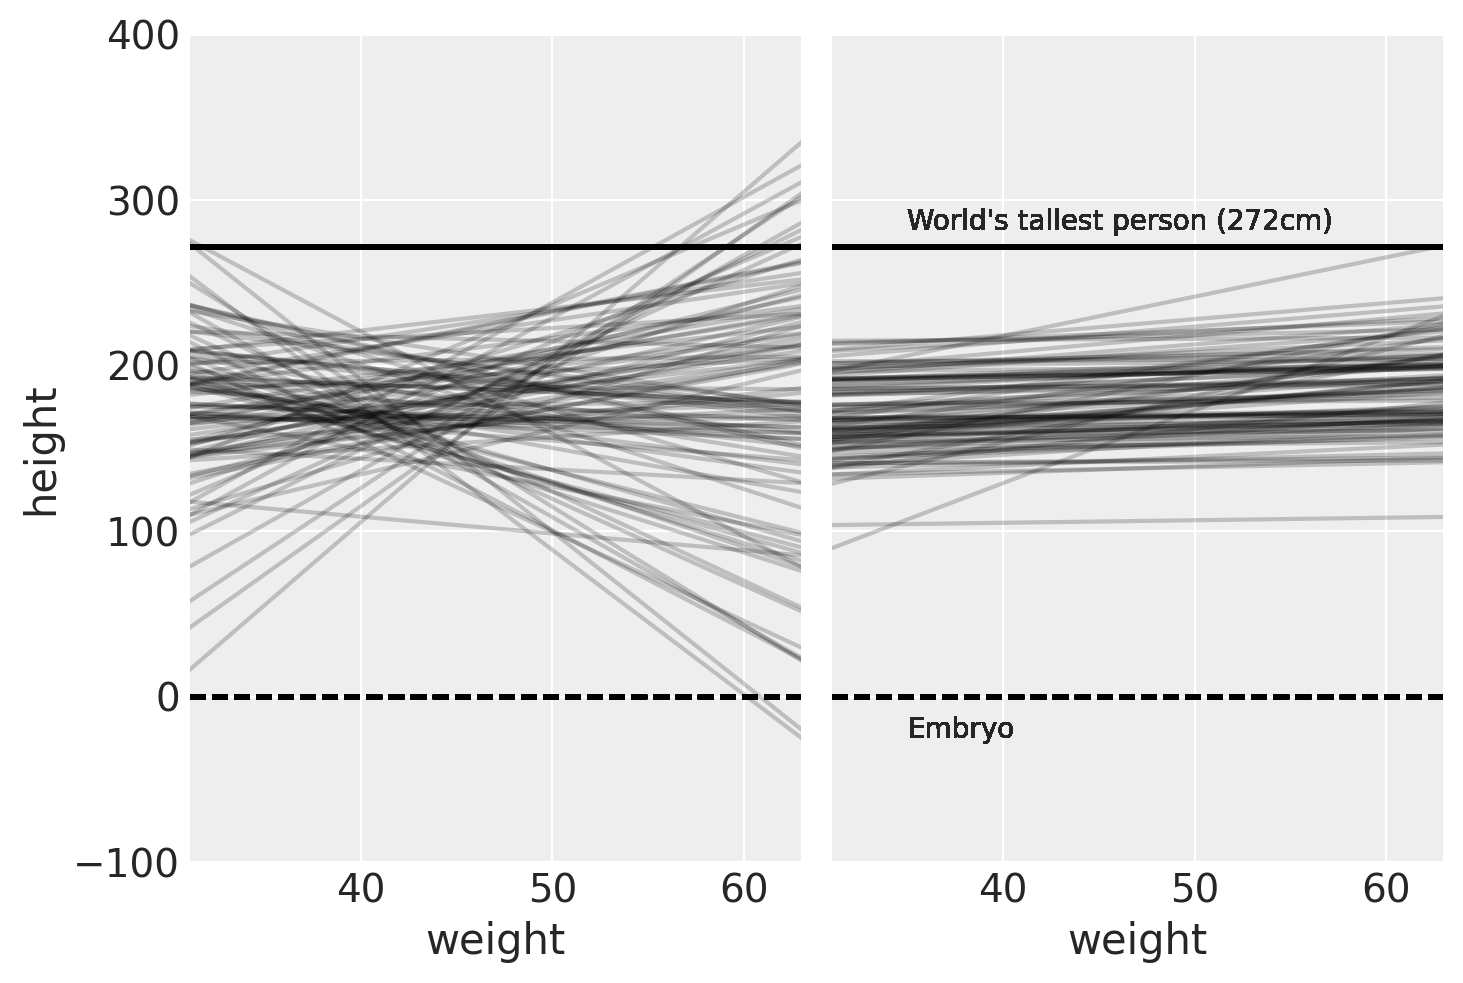

In [68]:
_, ax = plt.subplots(1, 2, sharey=True)
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), N)
for i in range(N):
    ax[0].plot(a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[0].set_xlim(d2.weight.min(), d2.weight.max())
    ax[0].set_ylim(-100, 400)
    ax[0].axhline(0, c="k", ls="--")
    ax[0].axhline(272, c="k")
    ax[0].set_xlabel("weight")
    ax[0].set_ylabel("height")

b = stats.lognorm.rvs(s=1, scale=1, size=100)
for i in range(N):
    ax[1].plot(a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[1].set_xlim(d2.weight.min(), d2.weight.max())
    ax[1].set_ylim(-100, 400)
    ax[1].axhline(0, c="k", ls="--", label="embryo")
    ax[1].axhline(272, c="k")
    ax[1].set_xlabel("weight")
    ax[1].text(x=35, y=282, s="World's tallest person (272cm)")
    ax[1].text(x=35, y=-25, s="Embryo");

#### Code 4.42

In [69]:
with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * (d2.weight - xbar)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_3 = pm.sample(1000, tune=1000)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  import sys
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


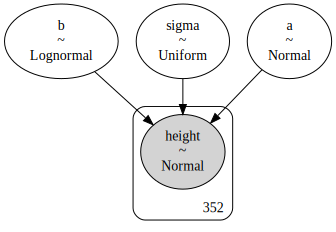

In [70]:
pm.model_to_graphviz(m4_3)

In [71]:
with pm.Model() as m4_3b:
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Normal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + np.exp(b) * (d2.weight - xbar)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_3b = pm.sample(1000, tune=1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  import sys
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


#### Code 4.44

In [72]:
az.summary(trace_4_3, kind="stats")

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_5.5%  hdi_94.5%
a      154.609  0.288   154.141    155.053
b        0.903  0.043     0.839      0.978
sigma    5.104  0.206     4.779      5.433

#### Code 4.45

In [73]:
trace_4_3_df = pm.trace_to_dataframe(trace_4_3)
trace_4_3_df.cov().round(3)

a      b  sigma
a      0.083 -0.000  0.000
b     -0.000  0.002 -0.000
sigma  0.000 -0.000  0.042

#### Code 4.46

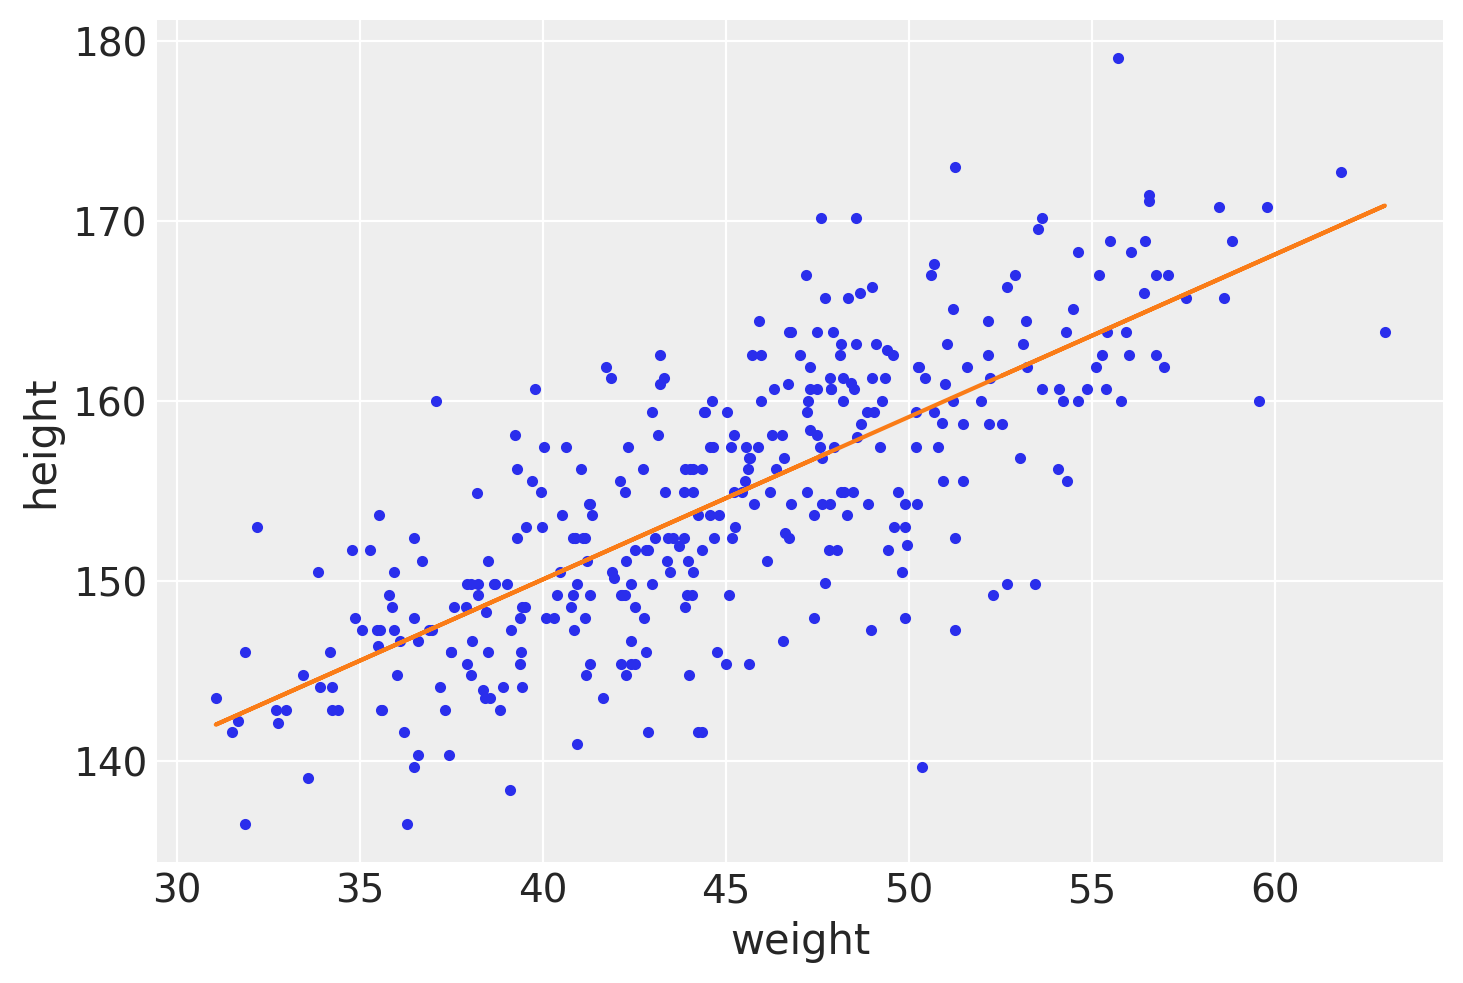

In [74]:
plt.plot(d2.weight, d2.height, ".")
plt.plot(d2.weight, trace_4_3["a"].mean() + trace_4_3["b"].mean() * (d2.weight - xbar))
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

#### Code 4.47

In [ ]:
trace_4_3_df.head(5)

a         b     sigma
0  154.563428  0.920924  5.313333
1  154.572958  0.810634  5.120046
2  154.661075  0.818422  5.022869
3  154.677476  0.980186  5.164795
4  154.530519  0.840830  4.990364

#### Code 4.48

In [75]:
N = [10, 50, 150, 352][0]
dN = d2[:N]
with pm.Model() as m_N:
    a = pm.Normal("a", mu=178, sd=100)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic("mu", a + b * (dN.weight - dN.weight.mean()))
    height = pm.Normal("height", mu=mu, sd=sigma, observed=dN.height)
    trace_N = pm.sample(1000, tune=1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if __name__ == '__main__':
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


#### Code 4.49

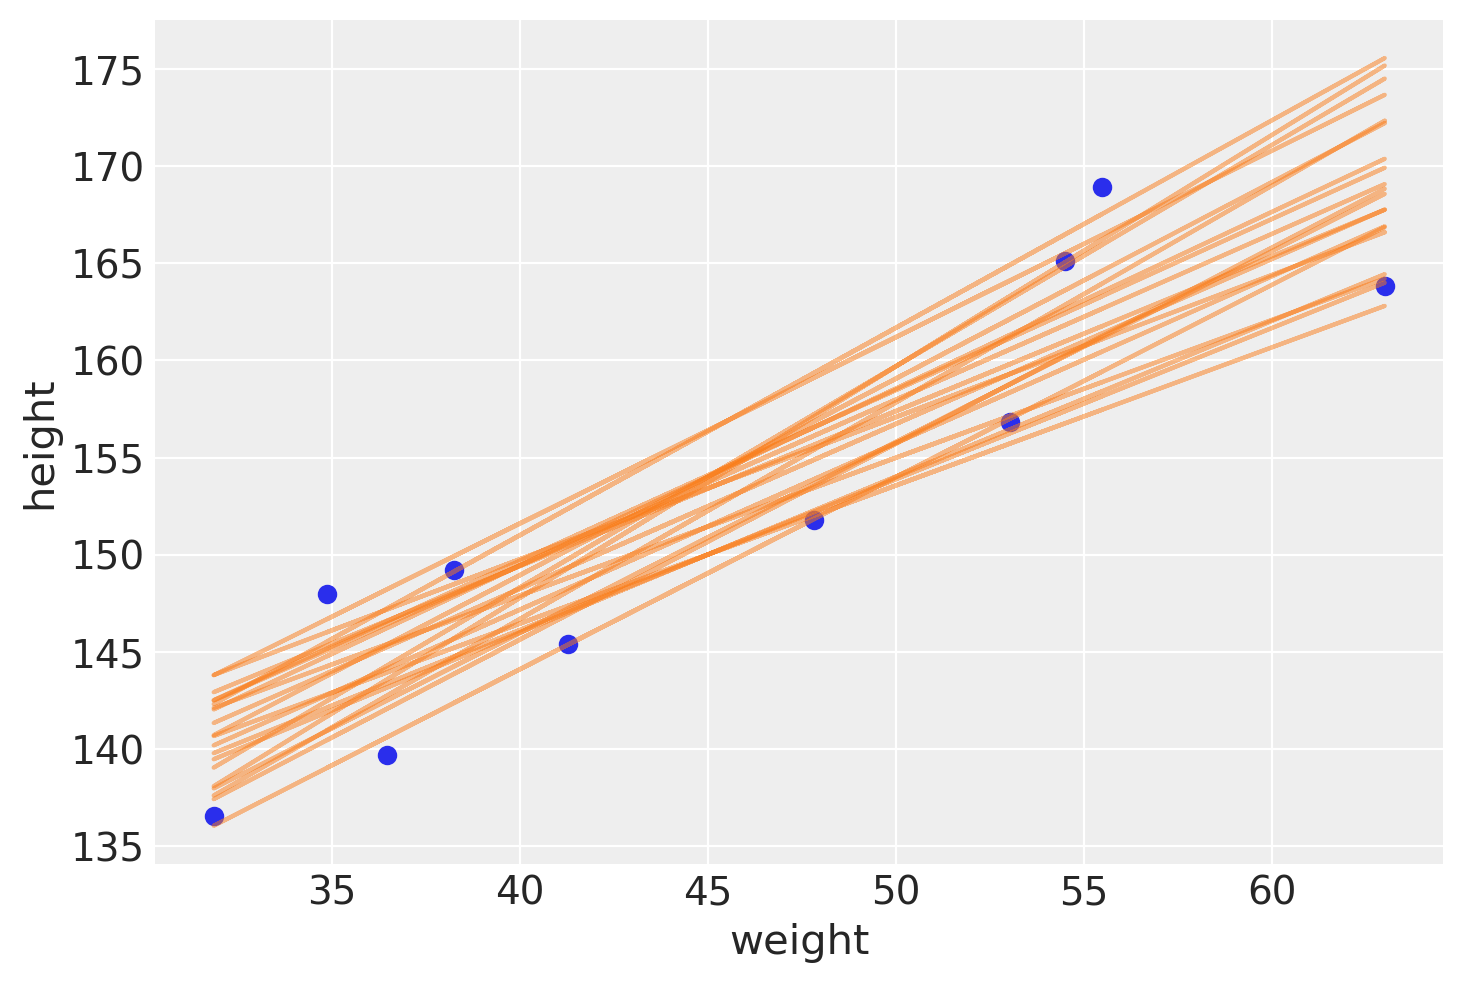

In [ ]:
plt.plot(dN.weight, dN.height, "C0o")
idxs = np.random.randint(len(trace_N), size=20)
for idx in idxs:
    plt.plot(
        dN.weight,
        trace_N["a"][idx] + trace_N["b"][idx] * (dN.weight - dN.weight.mean()),
        "C1-",
        alpha=0.5,
    )
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

Alternative we can directly use the deterministic `mu` variable

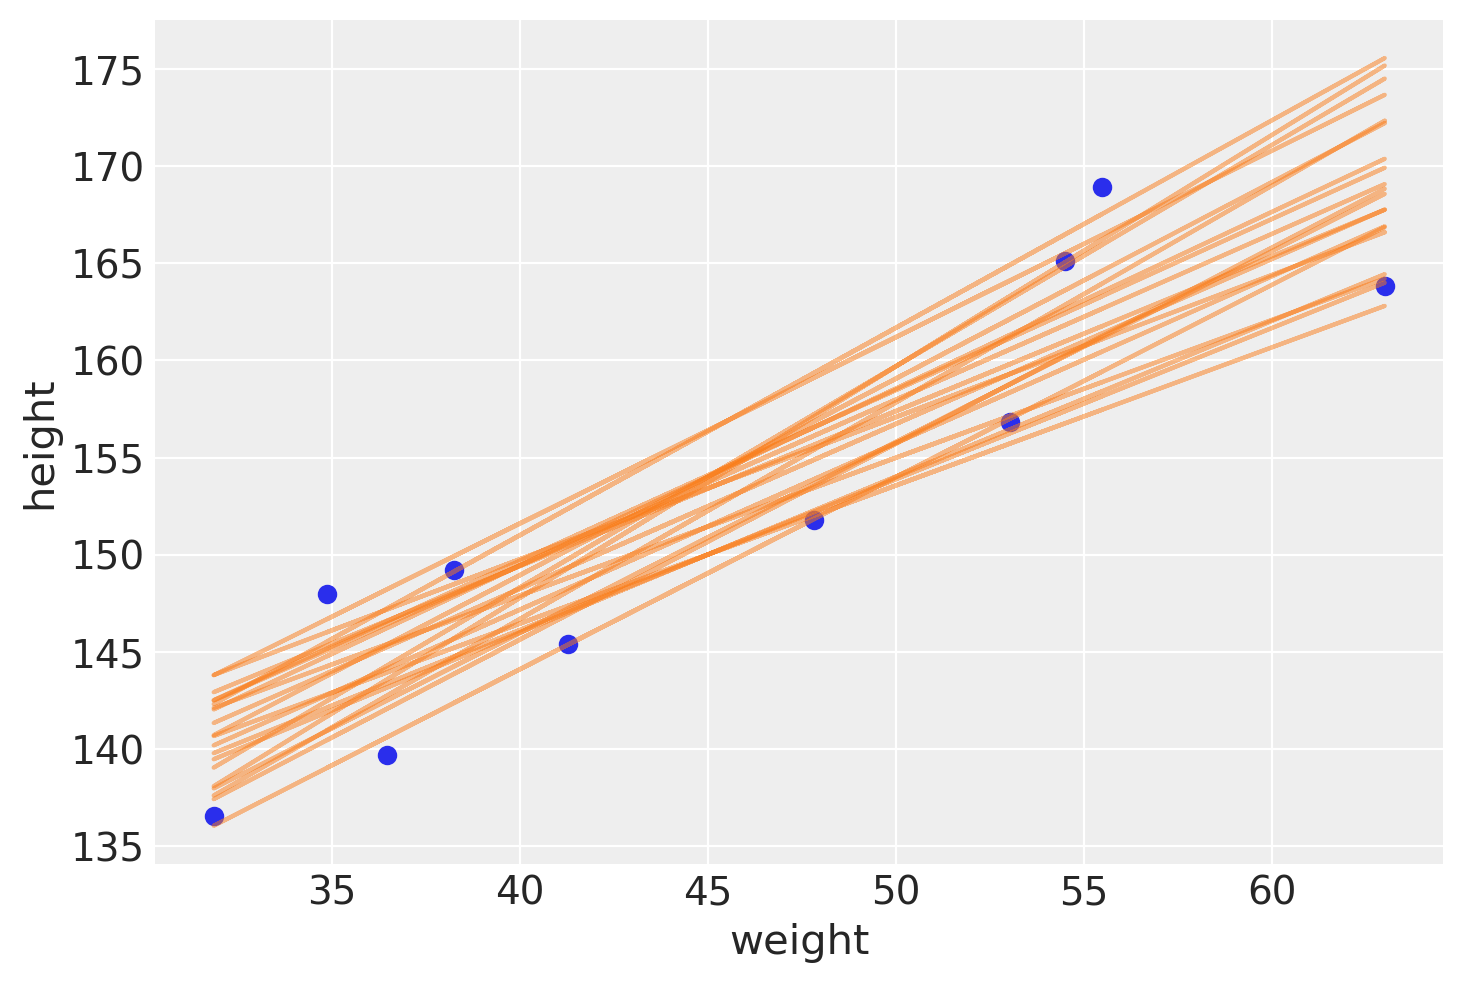

In [ ]:
plt.plot(dN.weight, dN.height, "C0o")
for idx in idxs:
    plt.plot(d2.weight[:N], trace_N["mu"][idx], "C1-", alpha=0.5)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

#### Code 4.50

In [ ]:
mu_at_50 = trace_4_3["a"] + trace_4_3["b"] * (50 - d2.weight.mean())

#### Code 4.51

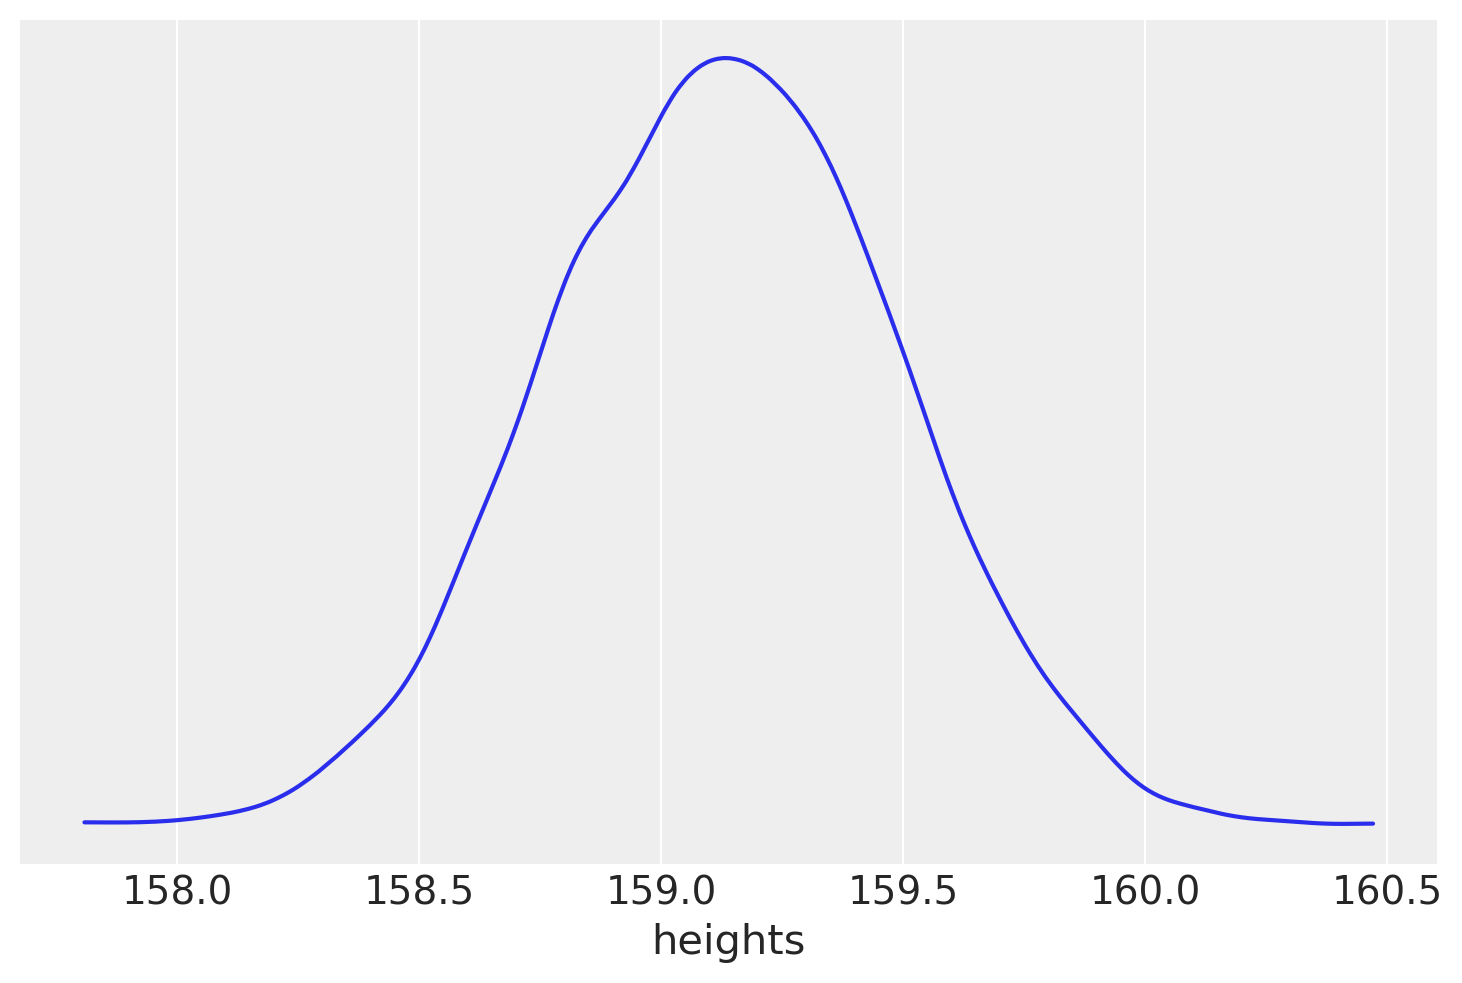

In [ ]:
az.plot_kde(mu_at_50)
plt.xlabel("heights")
plt.yticks([]);

#### Code 4.52

In [ ]:
az.hdi(mu_at_50)

array([158.5678297 , 159.69102145])

#### Code 4.53 and 4.54

We are doing _manually_, in the book is done using the ```link``` function. In the book on code 4.58 the following operations are performed _manually_.

In [ ]:
weight_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
trace_4_3_thinned = trace_4_3[::10]
mu_pred = np.zeros((len(weight_seq), len(trace_4_3_thinned) * trace_4_3.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = trace_4_3_thinned["a"] + trace_4_3_thinned["b"] * (w - d2.weight.mean())

#### Code 4.55

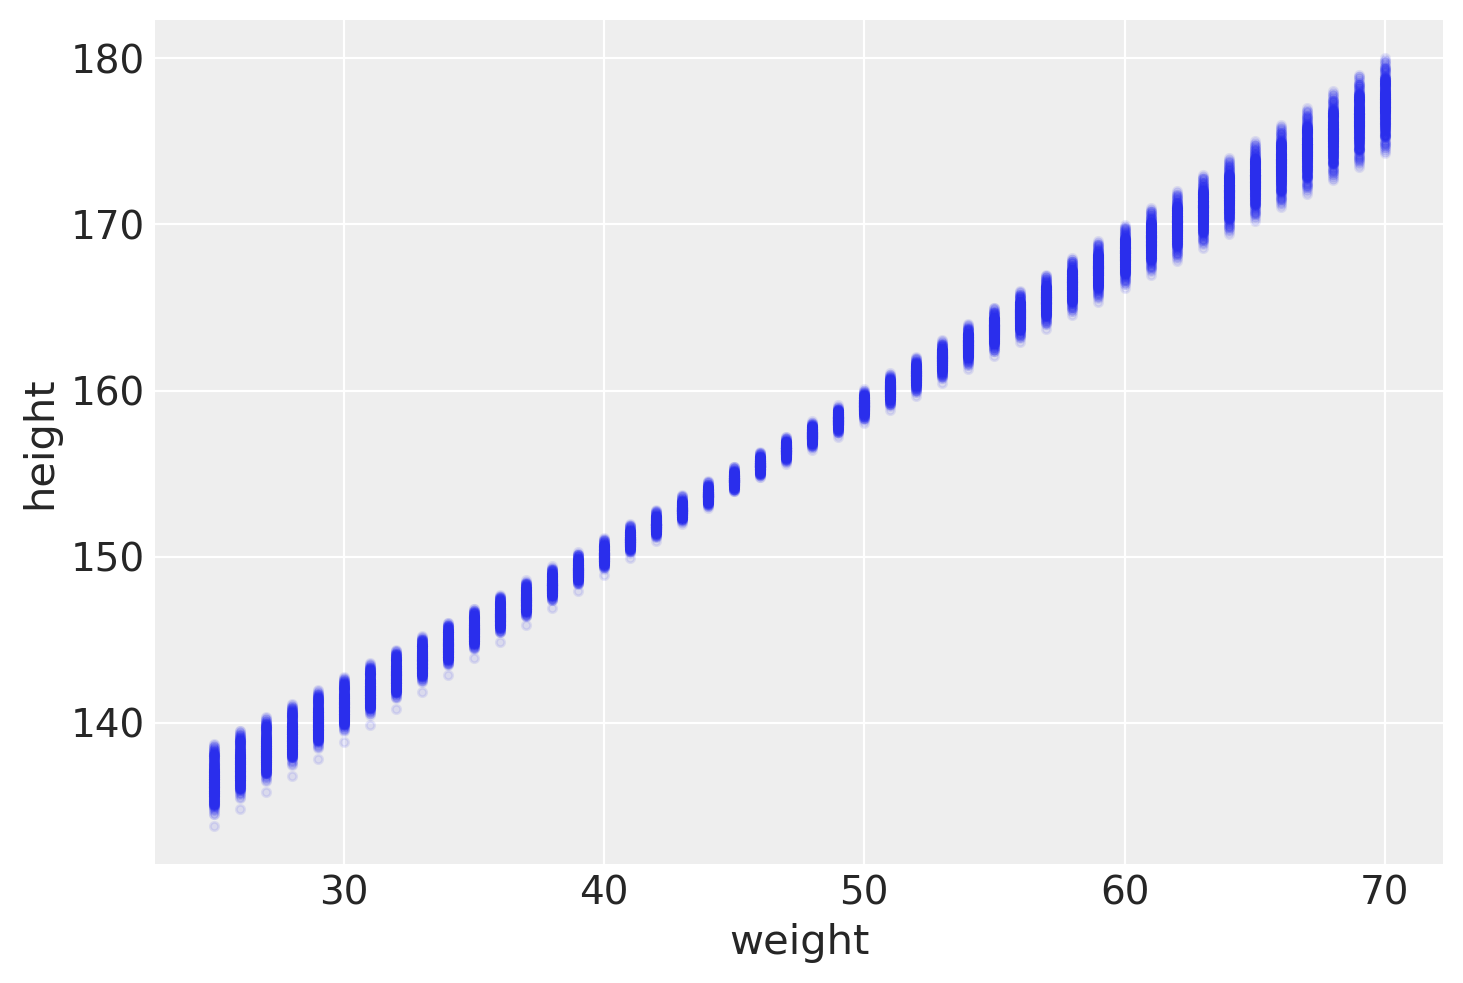

In [ ]:
plt.plot(weight_seq, mu_pred, "C0.", alpha=0.1)
plt.xlabel("weight")
plt.ylabel("height");

#### Code 4.56

In [ ]:
mu_mean = mu_pred.mean(1)
mu_hdi = az.hdi(mu_pred.T)

/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


#### Code 4.57

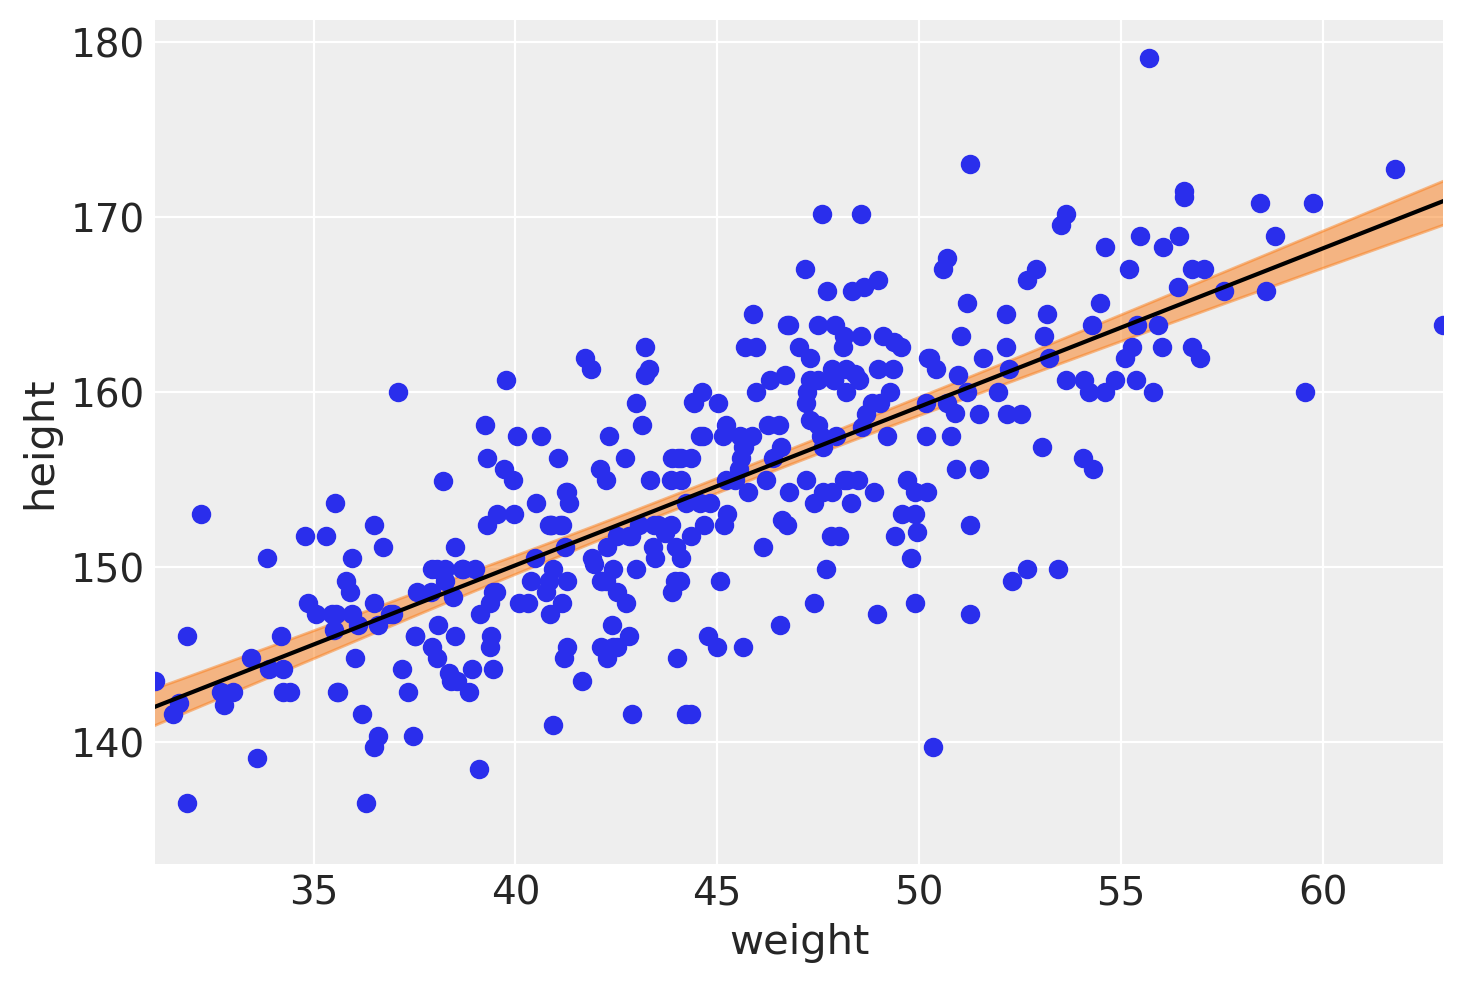

In [ ]:
az.plot_hdi(weight_seq, mu_pred.T)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.59

Now we are going to use ```sample_posterior_predictive()``` from PyCM3. This function gives us posterior predictive samples, that is for each value of the input variable we get a sample (from the posterior) of the output variable. Thus in the following example the shape of `height_pred['height'].shape is (200, 352)`

In [ ]:
height_pred = pm.sample_posterior_predictive(trace_4_3, 200, m4_3)

/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/pymc/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


#### Code 4.60

In [ ]:
height_pred_hdi = az.hdi(height_pred["height"])

/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


#### Code 4.61

/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


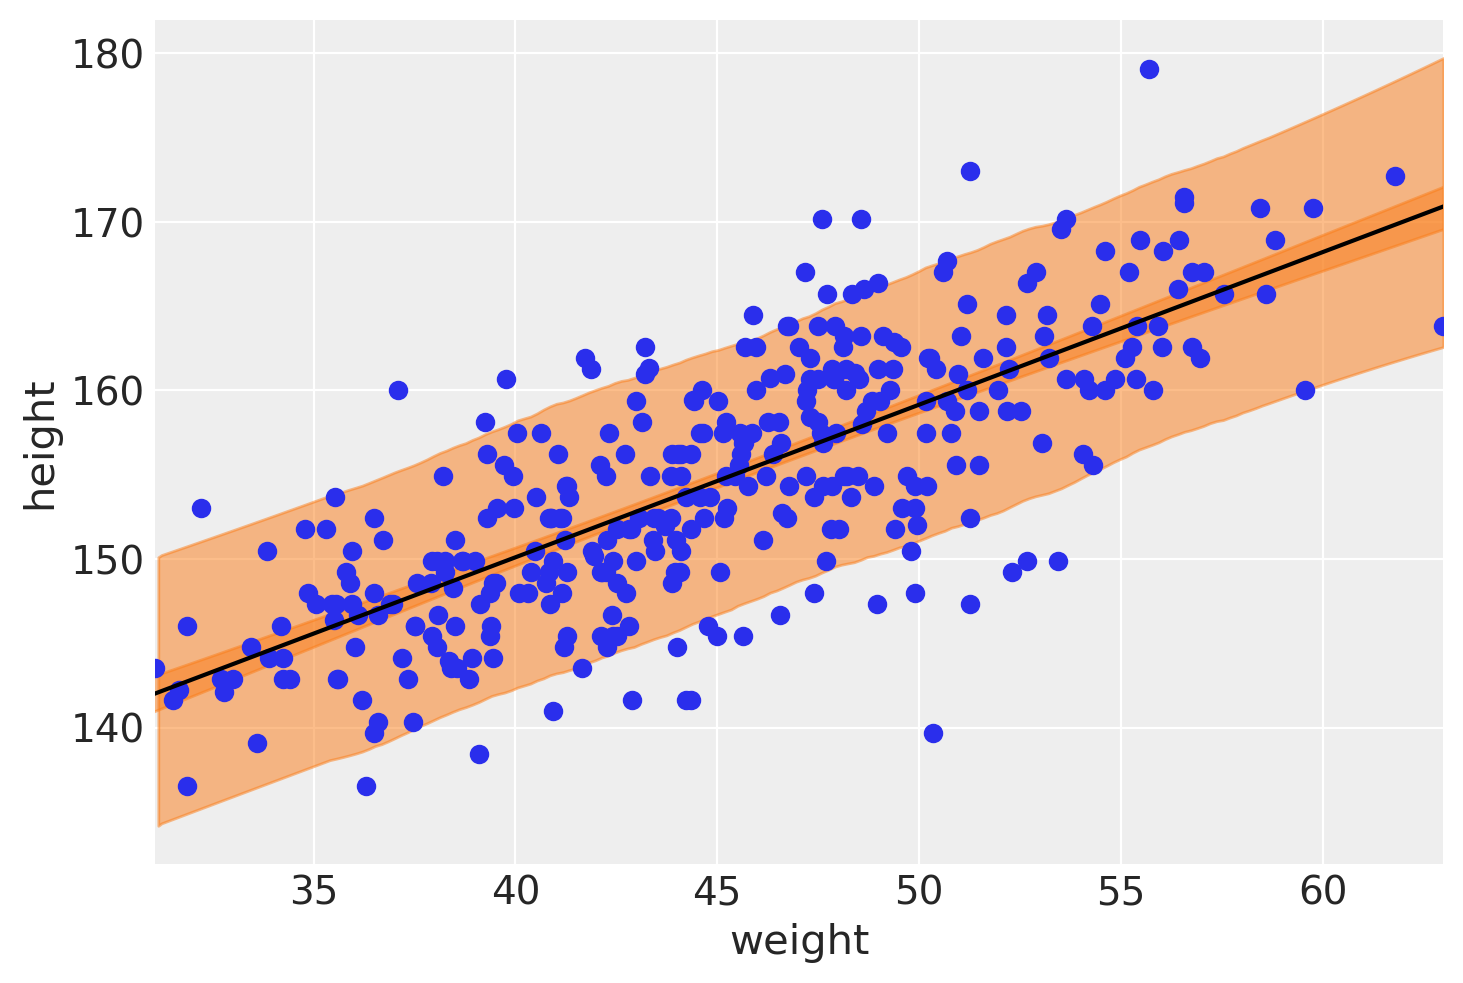

In [ ]:
ax = az.plot_hdi(weight_seq, mu_pred.T)
az.plot_hdi(d2.weight, height_pred["height"], ax=ax)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.62

Change the number of samples used in 4.59 (200) to other values.

#### Code 4.63

Now we are going to generate heights from the posterior *manually*. Instead of restricting ourselves to the input values, we are going to pass an array of equally spaced weights values, called `weight_seg`.

In [ ]:
weight_seq = np.arange(25, 71)
post_samples = []
for _ in range(1000):  # number of samples from the posterior
    i = np.random.randint(len(trace_4_3))
    mu_pr = trace_4_3["a"][i] + trace_4_3["b"][i] * (weight_seq - d2.weight.mean())
    sigma_pred = trace_4_3["sigma"][i]
    post_samples.append(np.random.normal(mu_pr, sigma_pred))

/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


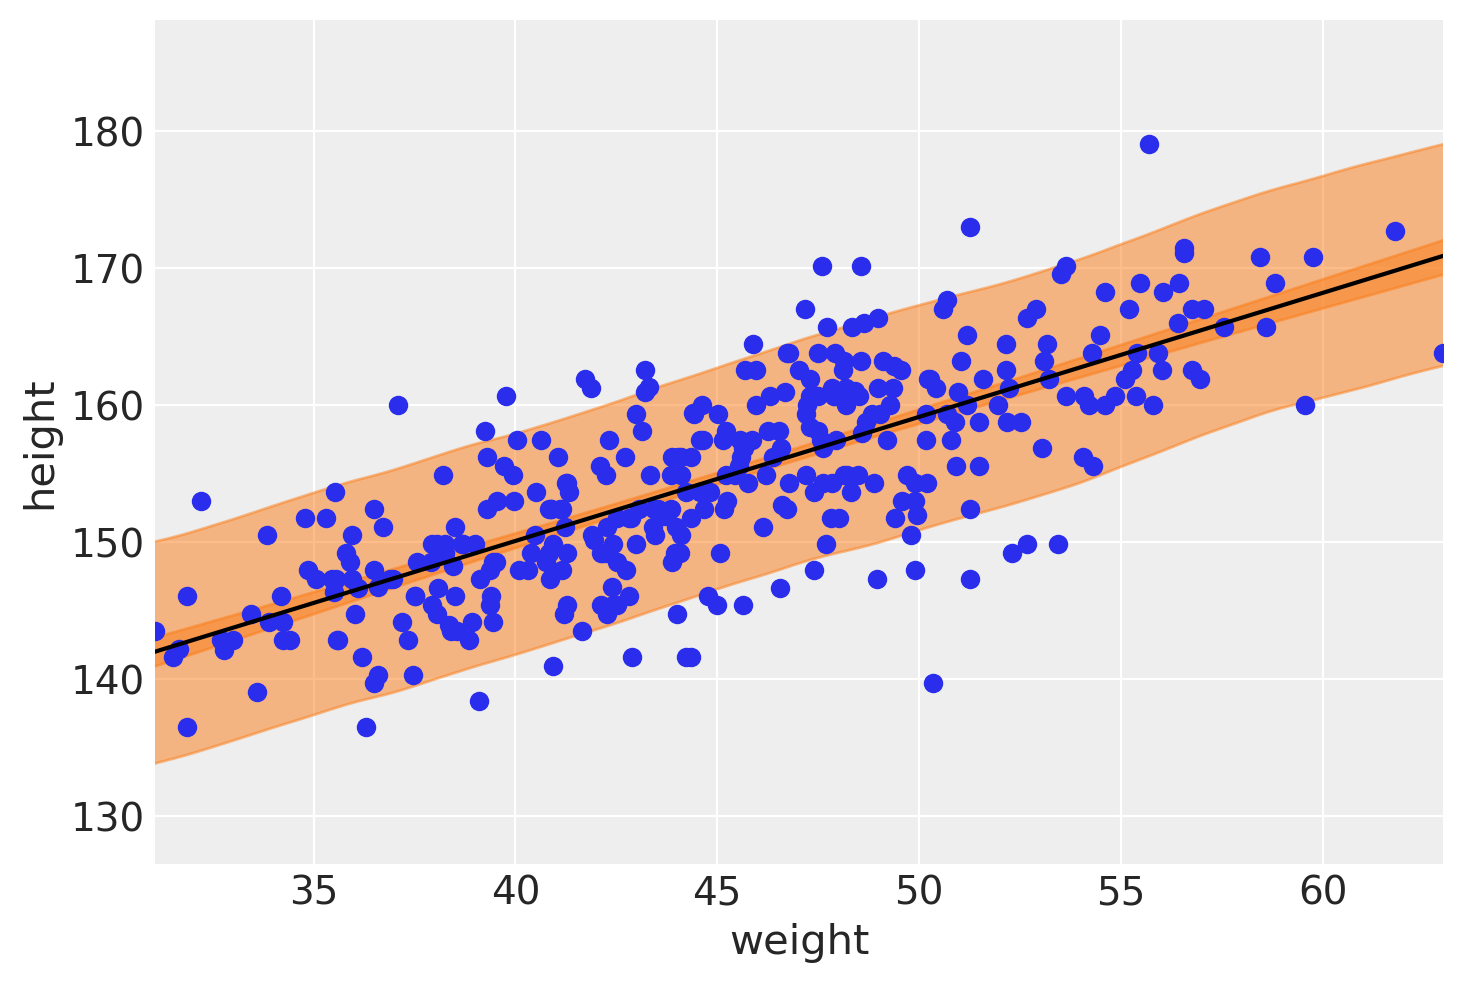

In [ ]:
ax = az.plot_hdi(weight_seq, mu_pred.T)
az.plot_hdi(weight_seq, np.array(post_samples), ax=ax)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.64

We have already loaded this dataset, check code 4.7 and 4.8.

In [ ]:
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

#### Code 4.65

In [ ]:
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_std2"] = d.weight_std ** 2

with pm.Model() as m_4_5:
    a = pm.Normal("a", mu=178, sd=100)
    b1 = pm.Lognormal("b1", mu=0, sd=1)
    b2 = pm.Normal("b2", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b1 * d.weight_std + b2 * d.weight_std2)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d.height)
    trace_4_5 = pm.sample(1000, tune=1000)

/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/pymc/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b2, b1, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


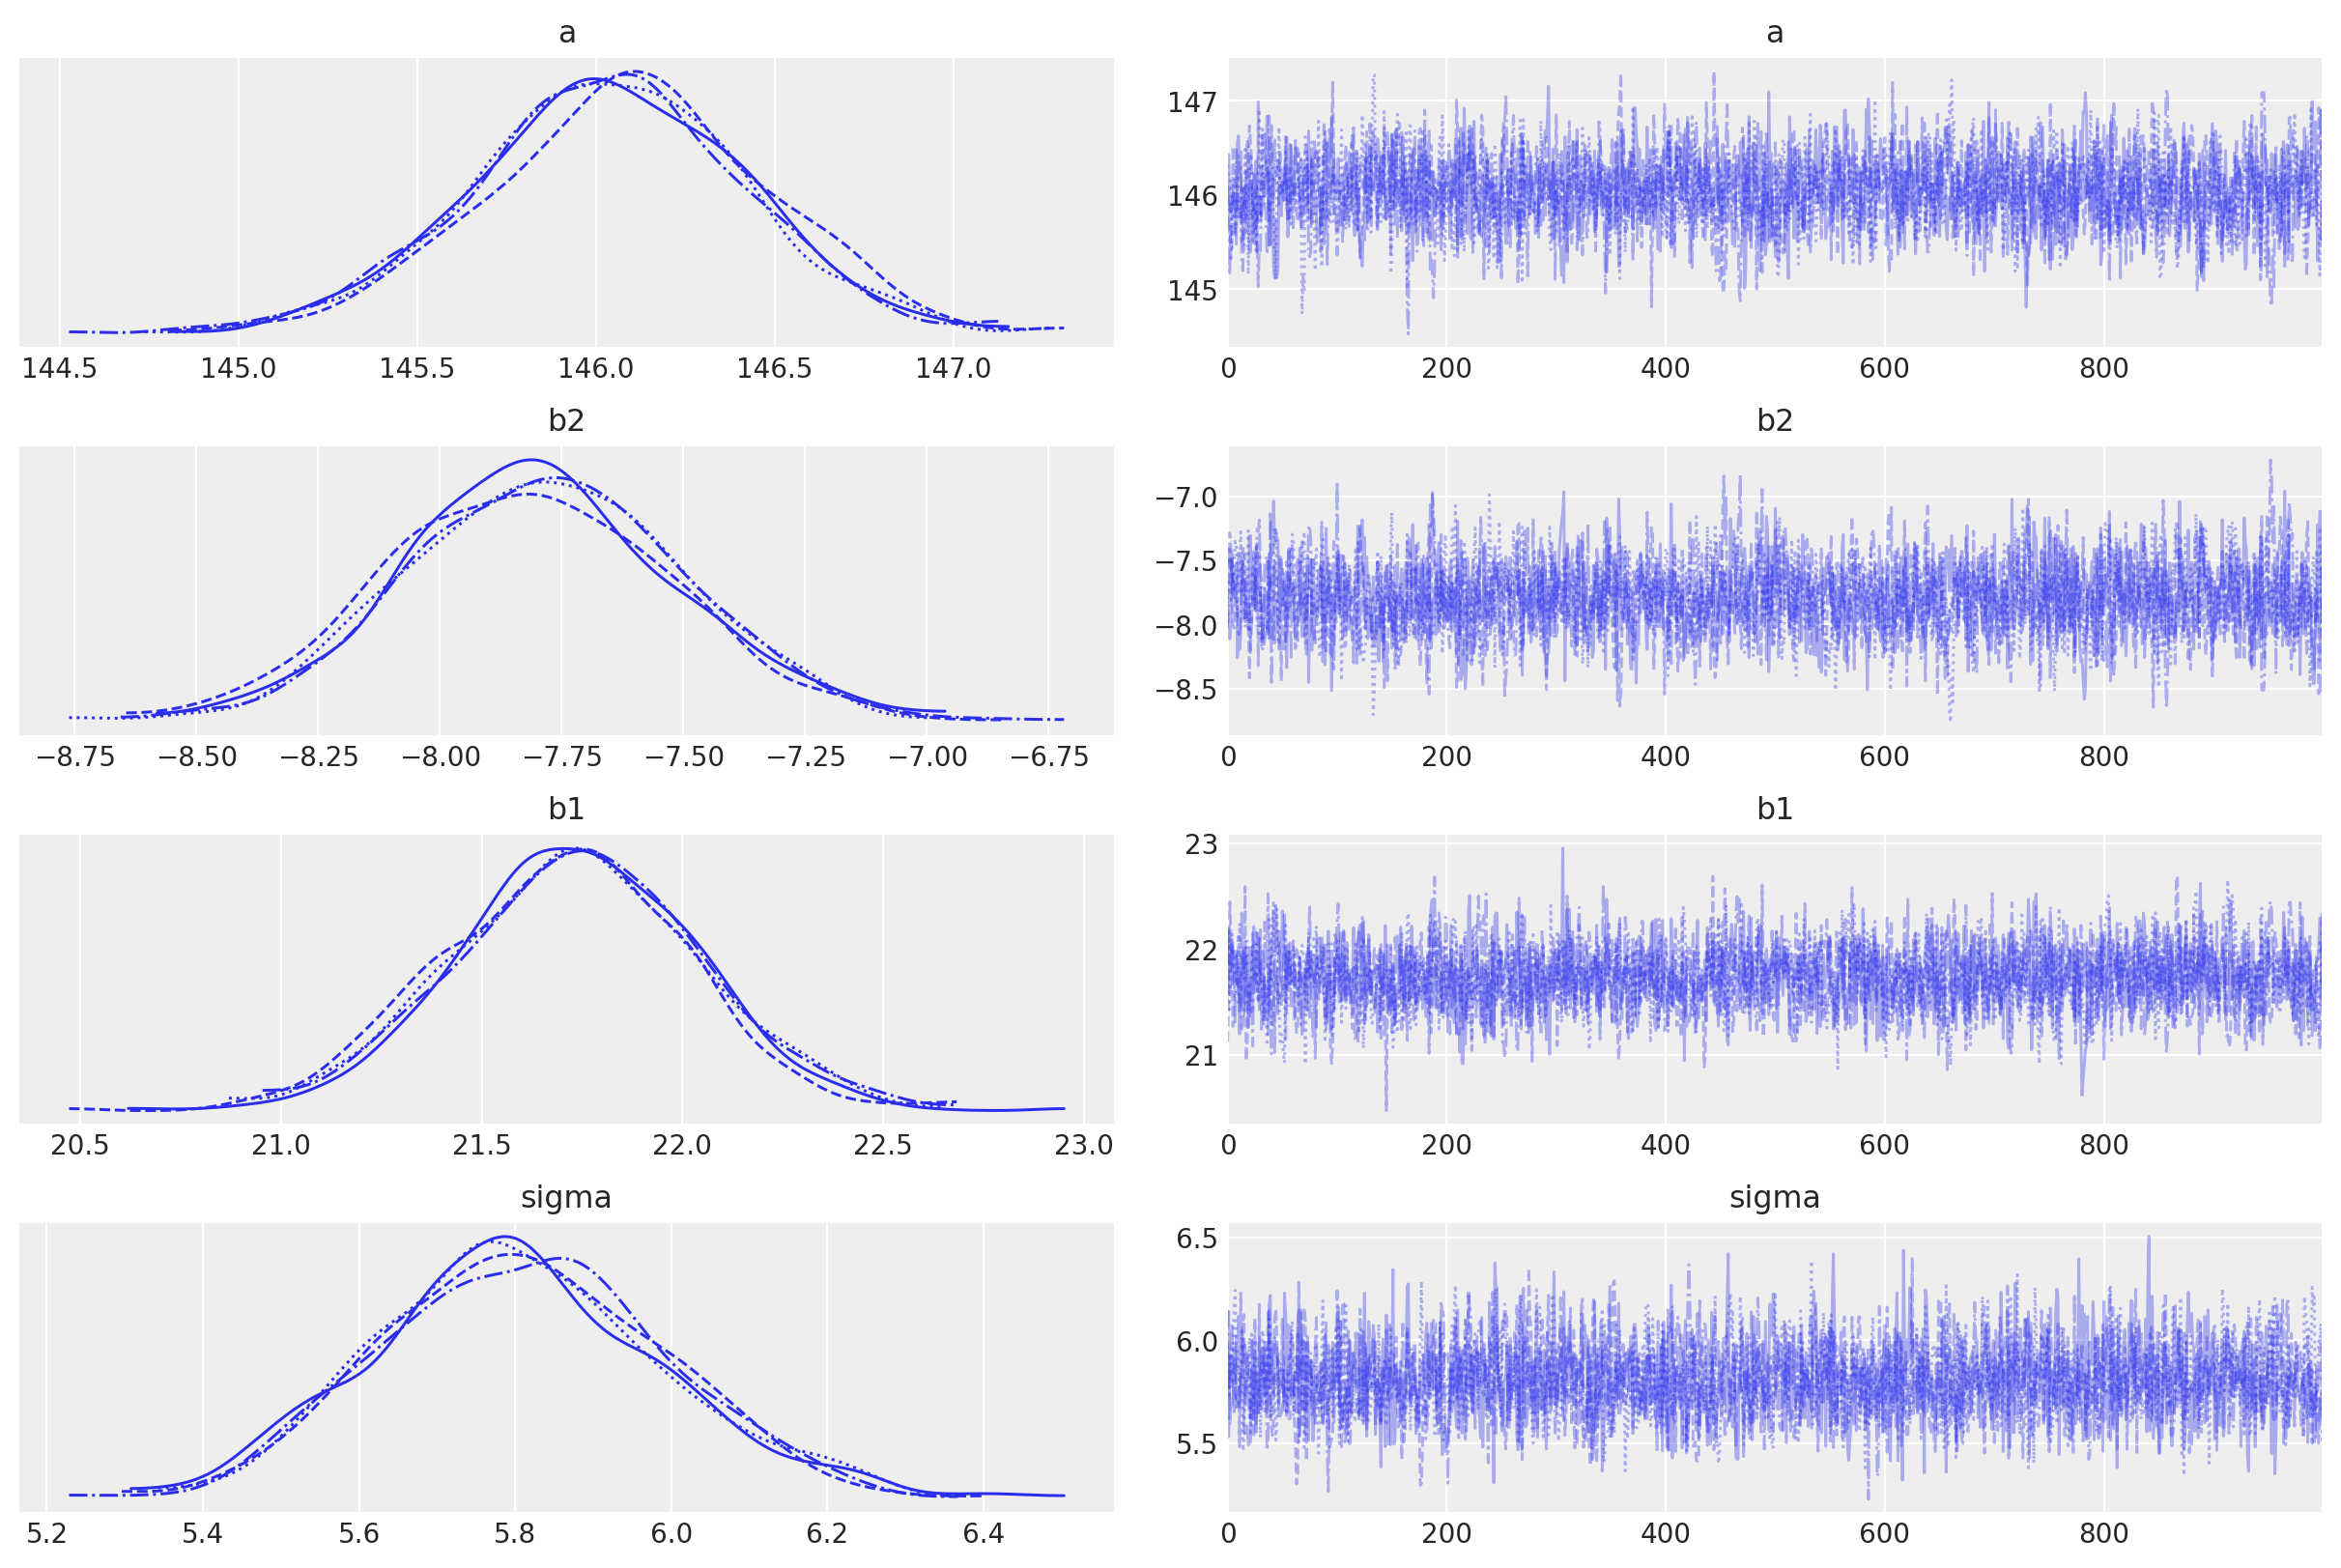

In [ ]:
varnames = ["~mu"]
az.plot_trace(trace_4_5, varnames);

#### Code 4.66

In [ ]:
az.summary(trace_4_5, varnames, kind="stats", round_to=2)

/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean    sd  hdi_5.5%  hdi_94.5%
a      146.05  0.38    145.39     146.62
b2      -7.80  0.28     -8.25      -7.35
b1      21.73  0.30     21.21      22.17
sigma    5.81  0.18      5.51       6.09

#### Code 4.67

In [ ]:
mu_pred = trace_4_5["mu"]
height_pred = pm.sample_posterior_predictive(trace_4_5, 200, m_4_5)

/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/pymc/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


#### Code 4.68

/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


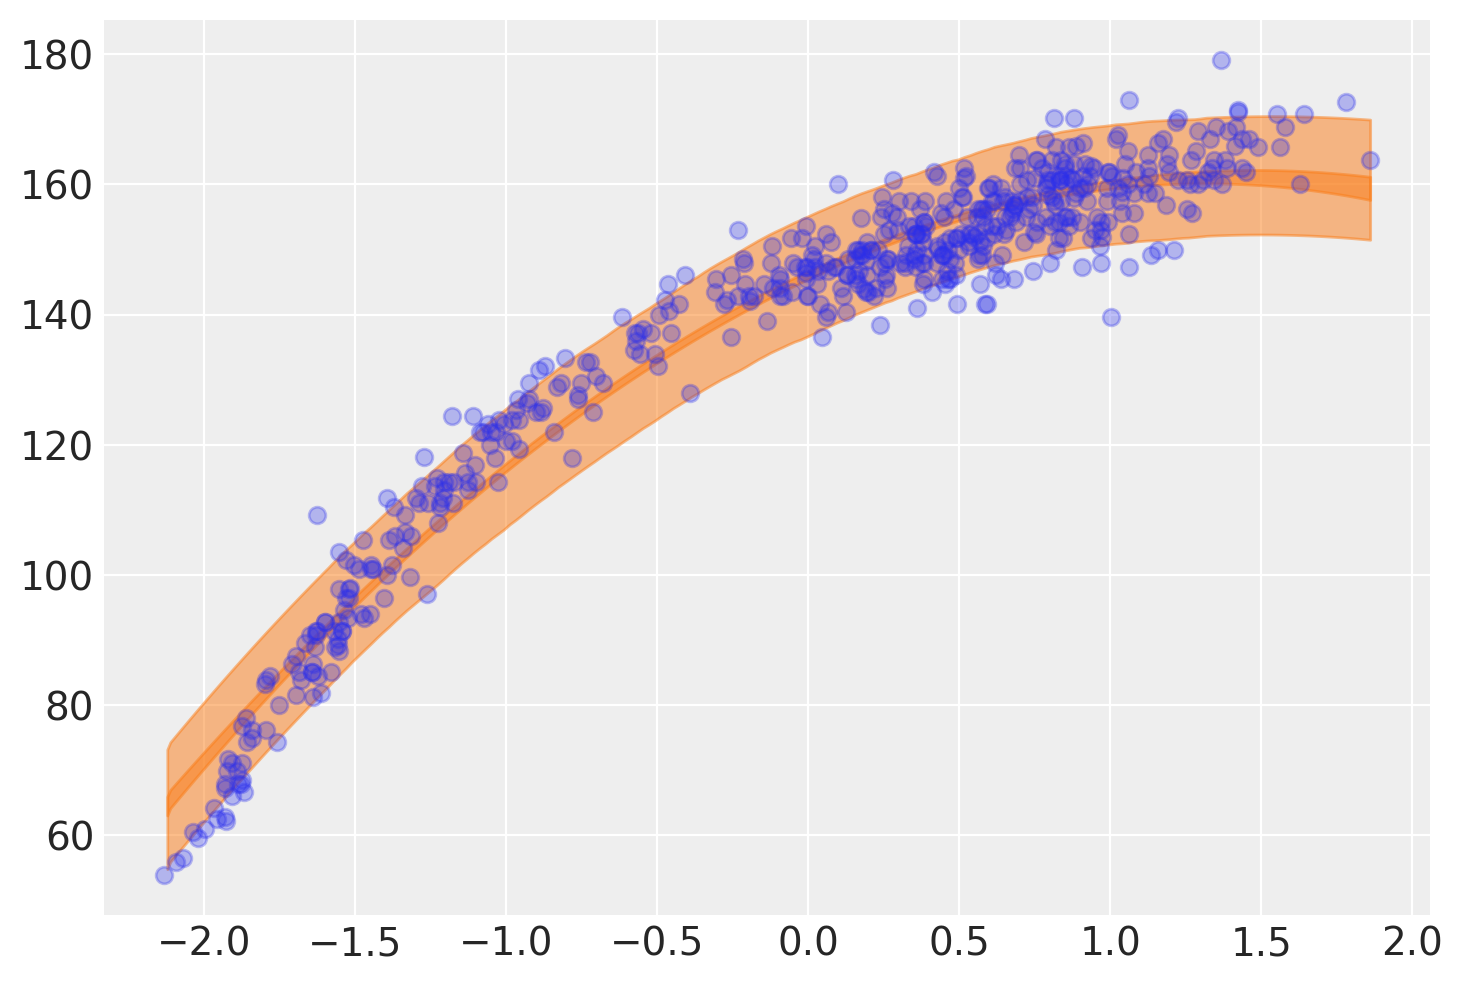

In [ ]:
ax = az.plot_hdi(d.weight_std, mu_pred)
az.plot_hdi(d.weight_std, height_pred["height"], ax=ax)
plt.scatter(d.weight_std, d.height, c="C0", alpha=0.3)

#### Code 4.69

We will stack the weights to get a 2D array, this simplifies writing a model. Now we can compute the dot product between beta and the 2D-array

In [ ]:
weight_m = np.vstack((d.weight_std, d.weight_std ** 2, d.weight_std ** 3))

In [ ]:
with pm.Model() as m_4_6:
    a = pm.Normal("a", mu=178, sd=100)
    b = pm.Normal("b", mu=0, sd=10, shape=3)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + pm.math.dot(b, weight_m))
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d.height)
    trace_4_6 = pm.sample(1000, tune=1000)

/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/pymc/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8862892489046332, but should be close to 0.8. Try to increase the number of tuning steps.


#### Code 4.70 and 4.71

/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/pymc/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


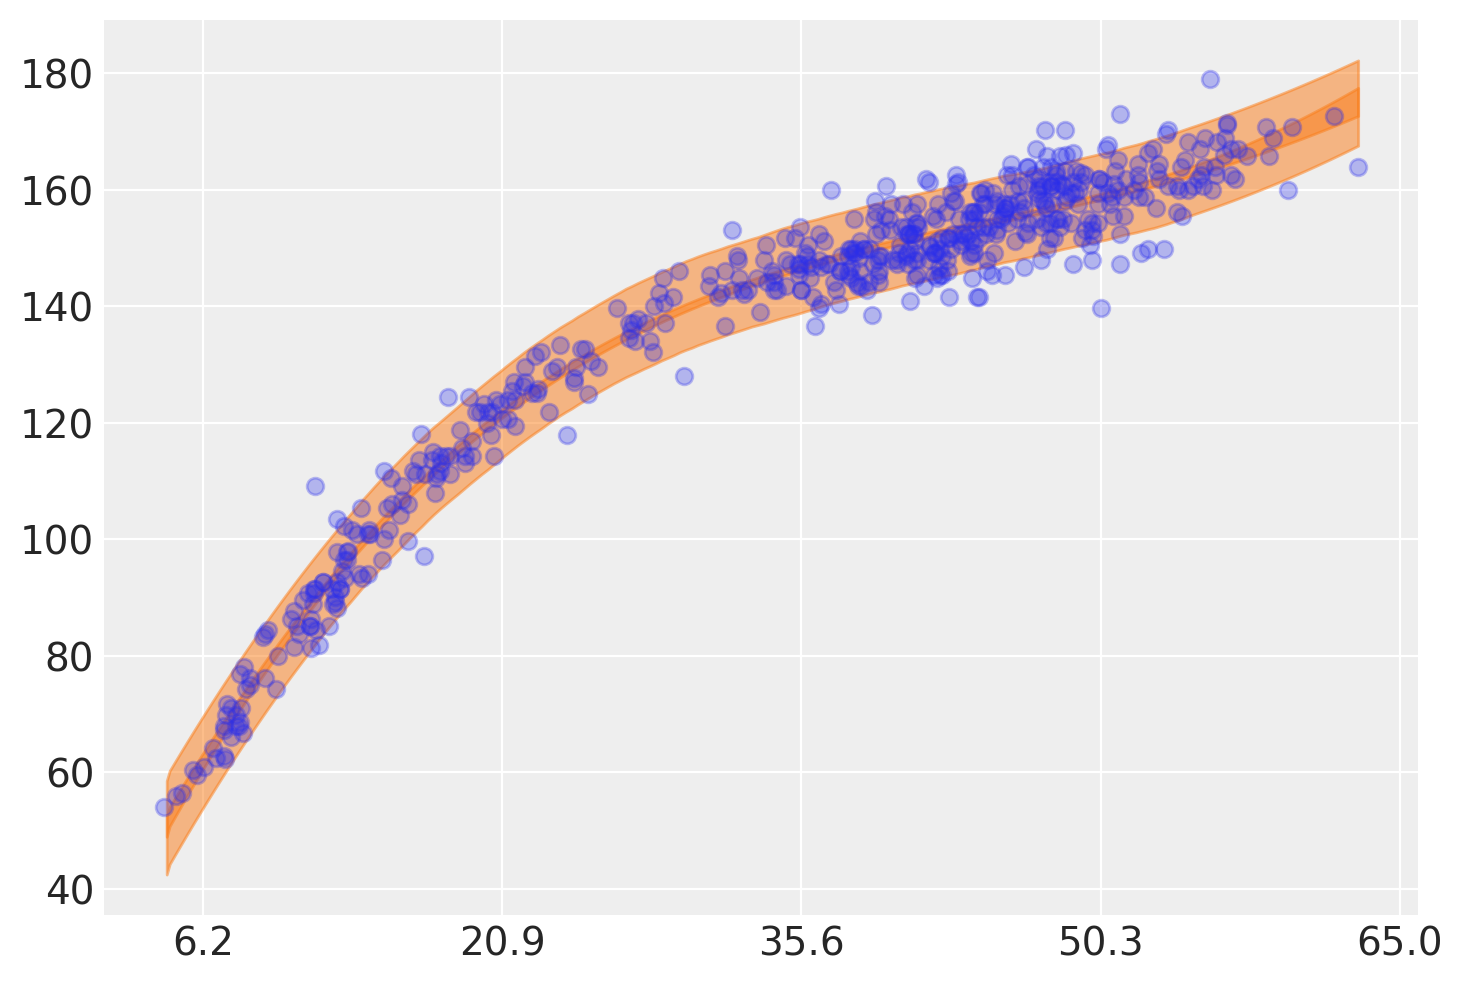

In [ ]:
mu_pred = trace_4_6["mu"]
height_pred = pm.sample_posterior_predictive(trace_4_6, 200, m_4_6)

ax = az.plot_hdi(d.weight_std, mu_pred)
az.plot_hdi(d.weight_std, height_pred["height"], ax=ax)
plt.scatter(d.weight_std, d.height, c="C0", alpha=0.3)

at = np.arange(-2, 3)
plt.xticks(at, np.round(at * d.weight.std() + d.weight.mean(), 1));

#### Code 4.72

In [ ]:
d = pd.read_csv("Data/cherry_blossoms.csv")
# nans are not treated as in the book
az.summary(d.dropna().to_dict(orient="list"), kind="stats")

mean       sd  hdi_5.5%  hdi_94.5%
year        1533.395  291.123   1123.00    1978.00
doy          104.921    6.258     95.00     114.00
temp           6.100    0.683      5.00       7.13
temp_upper     6.938    0.812      5.57       7.98
temp_lower     5.264    0.762      4.12       6.40

#### Code 4.73

In [ ]:
d2 = d.dropna(subset=["doy"])
num_knots = 15
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

#### Code 4.74

Here we will use patsy as a simple way of building the b-spline matrix. For more detail please read https://patsy.readthedocs.io/en/latest/spline-regression.html

In [ ]:
from patsy import dmatrix

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)

#### Code 4.75

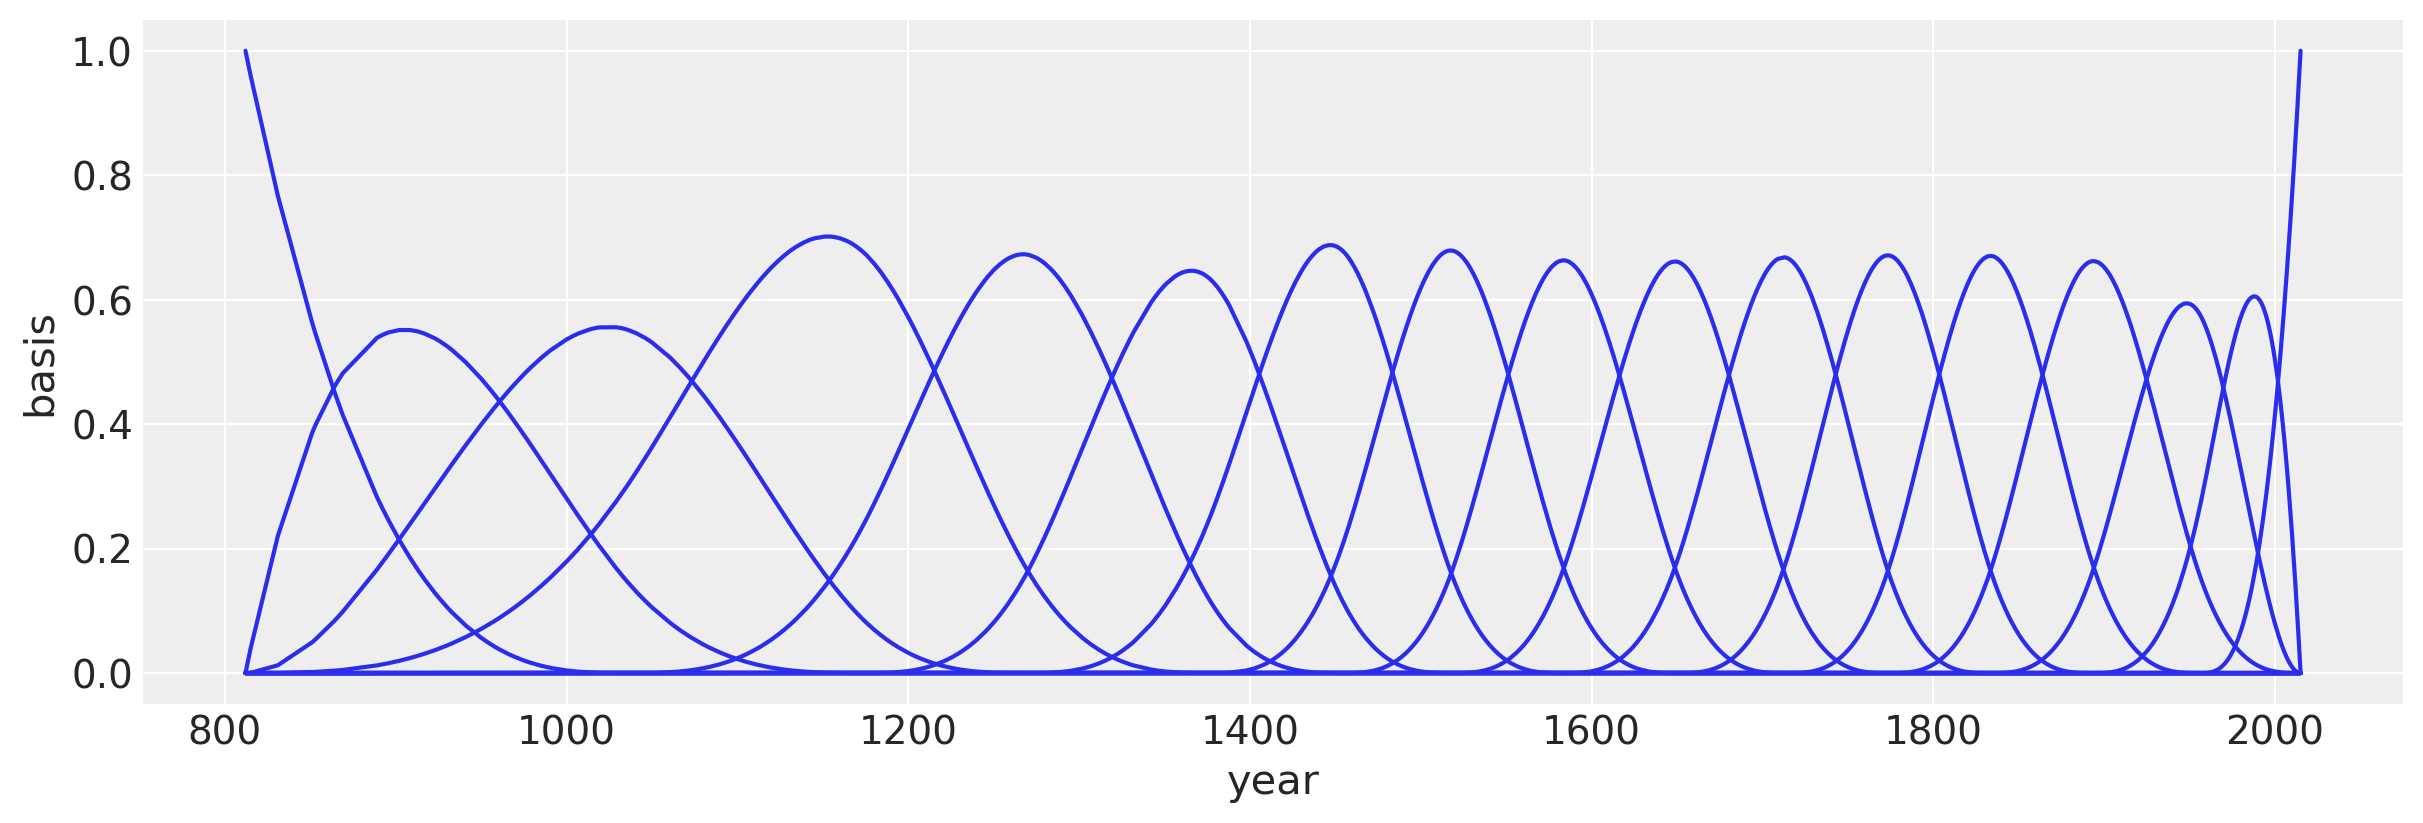

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(17):
    ax.plot(d2.year, (B[:, i]), color="C0")
ax.set_xlabel("year")
ax.set_ylabel("basis");

#### Code 4.76

Note: if the mode gets stall instead of sampling try replacing `mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))` with `mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))`

In [ ]:
with pm.Model() as m4_7:
    a = pm.Normal("a", 100, 10)
    w = pm.Normal("w", mu=0, sd=10, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    # mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d2.doy)
    trace_m4_7 = pm.sample(1000)

/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/pymc/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
The acceptance probability does not match the target. It is 0.8990466854497895, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


#### Code 4.77

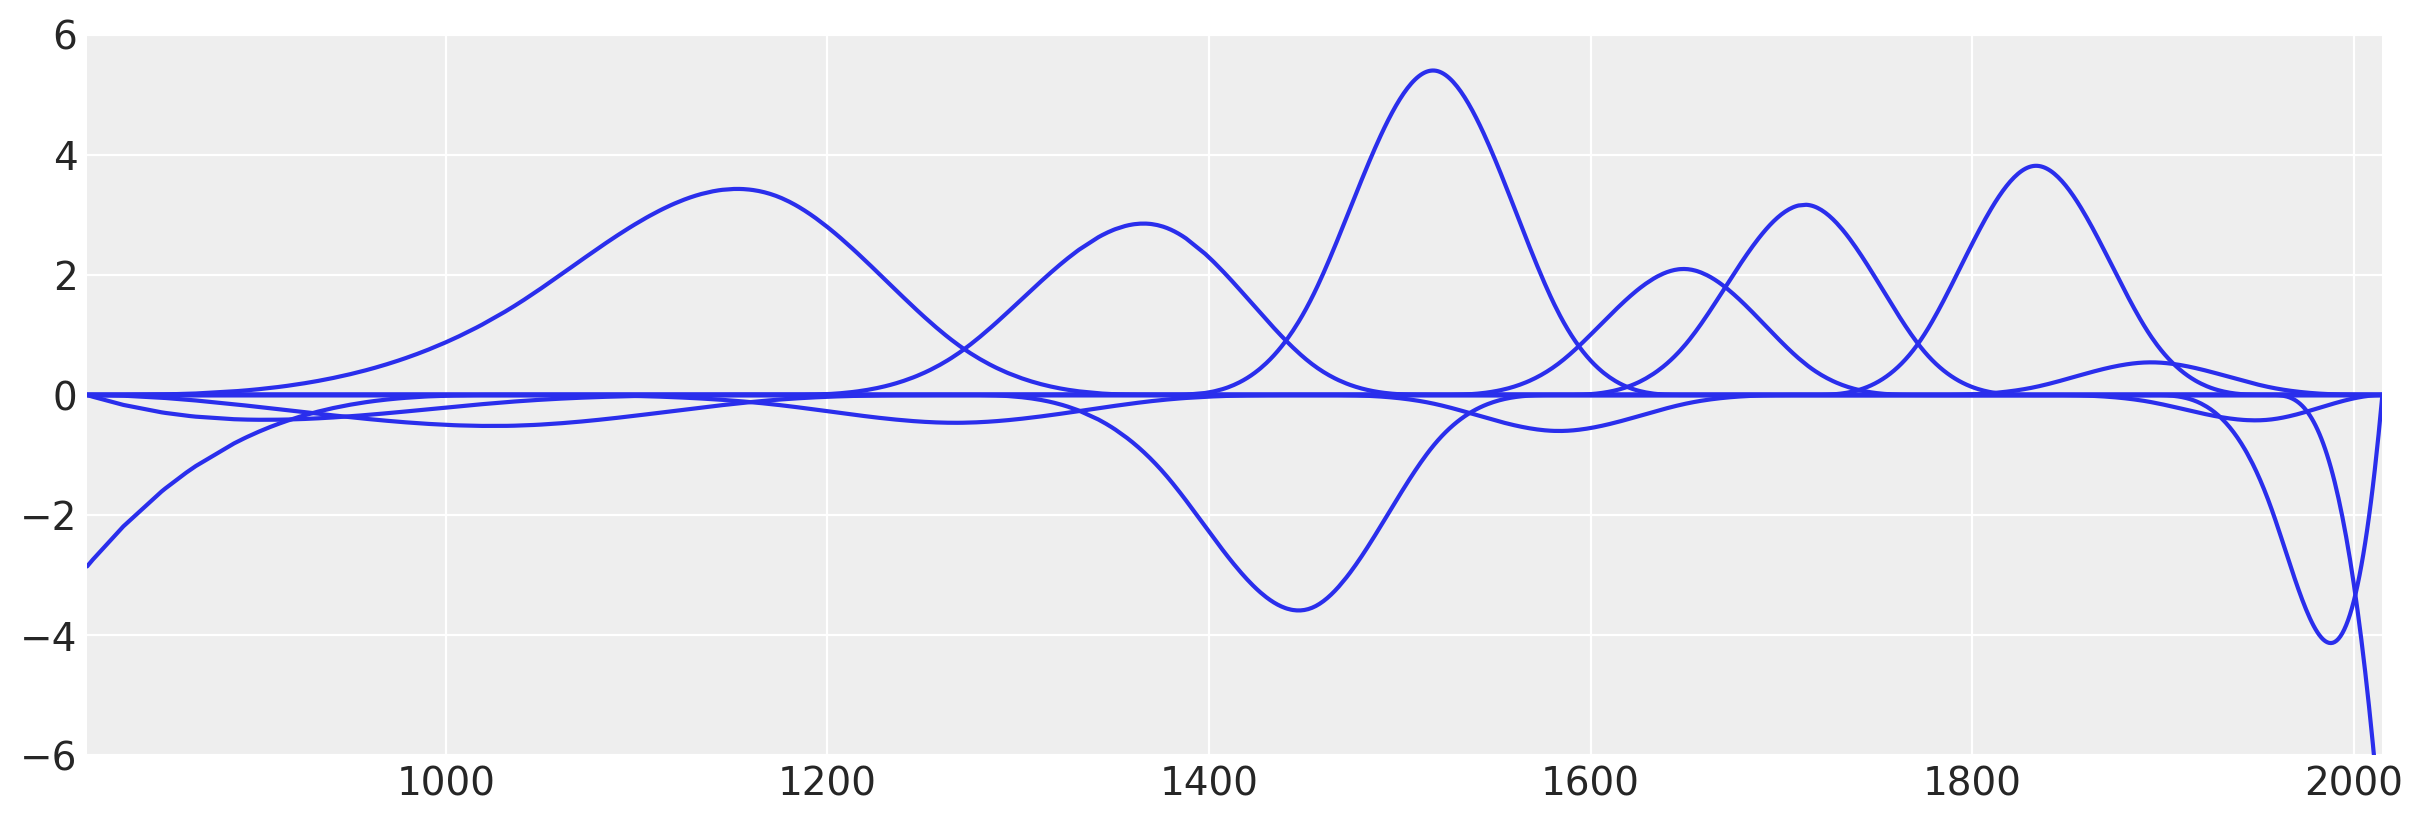

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
wp = trace_m4_7[w].mean(0)
for i in range(17):
    ax.plot(d2.year, (wp[i] * B[:, i]), color="C0")
ax.set_xlim(812, 2015)
ax.set_ylim(-6, 6);

#### Code 4.78

/home/damian/miniconda3/envs/stat-rethink2-pymc/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0, 0.5, 'days in year')

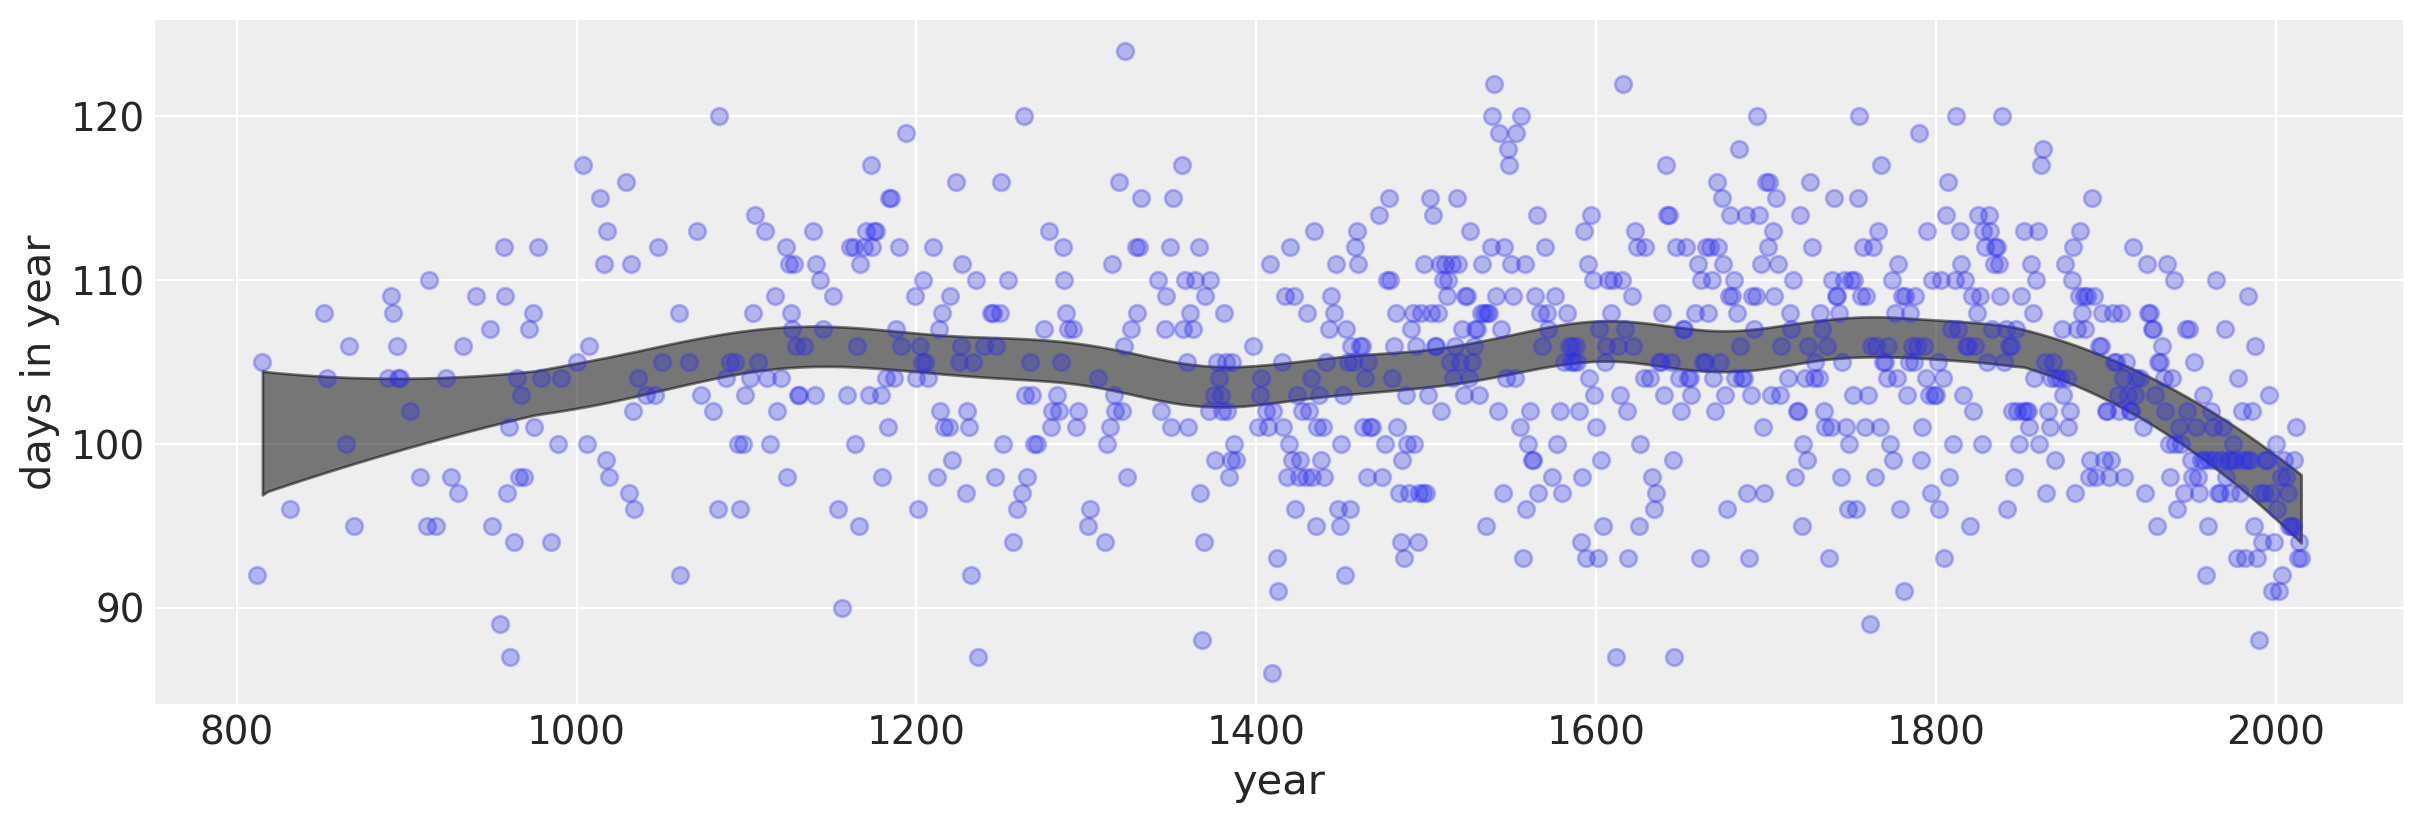

In [ ]:
ax = az.plot_hdi(d2.year, trace_m4_7["mu"], color="k")
ax.plot(d2.year, d2.doy, "o", alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(12, 4)
ax.set_xlabel("year")
ax.set_ylabel("days in year")

In [ ]:
%watermark -n -u -v -iv -w

Last updated: Fri Feb 19 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.20.0

seaborn   : 0.11.1
numpy     : 1.19.2
pymc     : 3.11.1
scipy     : 1.6.0
arviz     : 0.11.1
matplotlib: 3.3.4
pandas    : 1.2.1

Watermark: 2.2.0

